In [38]:
# Import all the required moduless
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Common function used within the program

In [147]:
# ROC Curve function

def draw_roc( model_name, actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc="lower right")
    plt.show()

    return auc_score


# Function to get best param and score for Logistic, RandomForest and DecisionTree
def fit_best_models(X_train, y_train, cv=5, n_jobs=-1):
    """
    Execute GridSearchCV for LogisticRegression, RandomForest and DecisionTree,
    then refits each model with its best parameters.
    
    Returns:
        best_models: dict of {model_name: fitted pipeline}
        best_params: dict of {model_name: best parameters}
        best_scores: dict of {model_name: best CV score}
    """

    models = {
        'logreg': LogisticRegression(),
        'rf': RandomForestClassifier(random_state=42),
        'dt': DecisionTreeClassifier(random_state=42)
    }
    pipelines = {
        'logreg': Pipeline([('scaler', StandardScaler()), ('clf', models['logreg'])]),
        'rf': Pipeline([('scaler', StandardScaler()), ('clf', models['rf'])]),  # scaler optional for RF/DT
        'dt': Pipeline([('scaler', StandardScaler()), ('clf', models['dt'])])
    }

    param_grids = {
        'logreg': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs', 'liblinear']
        },
        'rf': {
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2, 5]
        },
        'dt': {
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2, 5, 10],
            'clf__criterion': ['gini', 'entropy']
        }
    }
    
    best_models = {}
    best_params = {}
    best_scores = {}
    
    # Step 1: GridSearchCV for each model
    for name in models:
        gs = GridSearchCV(pipelines[name], param_grids[name], cv=cv, n_jobs=n_jobs)
        gs.fit(X_train, y_train)
        best_params[name] = gs.best_params_
        best_scores[name] = gs.best_score_
        # Step 2: Refit the pipeline with best parameters on full training data
        best_estimator_params = {k.replace('clf__', ''): v for k, v in gs.best_params_.items() if k.startswith('clf__')}
        model_cls = type(models[name])
        if name in ['rf', 'dt']:
            best_estimator_params['random_state'] = 42
        best_model = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model_cls(**best_estimator_params))
        ])
        best_model.fit(X_train, y_train)
        best_models[name] = best_model
        
    return best_models, best_params, best_scores


In [104]:
### Reading data as a pandas dataframe
df = pd.read_csv('data/creditcard.csv')

# Due to size and harware performance I am taking random 100,000 rows only for processing.
data = df.sample(n=50000, random_state=42)

del df

# Data Exploration

In [105]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


In [106]:
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
106498,69990.0,0.462363,-1.550233,0.874507,1.595693,-0.819377,2.172600,-0.812574,0.619746,1.529879,...,0.119895,0.102082,-0.530930,-1.251226,0.504400,-0.164403,0.056260,0.068515,338.00,0
283717,171815.0,1.972563,-0.000713,-1.954494,0.409805,0.402250,-0.818861,0.181189,-0.091878,0.313003,...,-0.211346,-0.656463,0.245418,0.637921,-0.203497,0.271014,-0.089187,-0.038181,32.04,0
14468,25632.0,-0.788040,-0.327733,1.747076,-2.612266,-0.155487,0.060404,0.287468,-0.133078,1.475529,...,0.280058,1.146401,-0.293311,-0.675839,-0.327425,-0.000669,-0.036724,-0.113928,105.92,0
283271,171486.0,-0.741114,0.585081,0.978985,-0.424461,1.555087,1.236085,0.510679,0.429463,-0.915042,...,-0.172254,-0.443694,-0.253624,-1.615967,0.192874,0.614091,0.025788,0.029221,0.99,0
274591,166102.0,-0.695279,0.328831,-0.943864,-2.912087,2.400622,3.461751,-0.176838,0.789615,-1.031595,...,-0.209670,-0.959245,0.155612,0.539474,-0.635385,-0.735911,-0.373982,0.217850,24.99,0


In [107]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,94951.926820,-0.002393,0.000194,0.001736,0.002464,0.002483,0.001580,-0.003289,0.000617,-0.002554,...,-0.001626,0.004298,0.000869,0.000401,0.003989,0.001055,0.001618,-0.001650,87.377714,0.00166
std,47485.451927,1.960996,1.631727,1.524856,1.414847,1.352321,1.316629,1.207910,1.212368,1.105842,...,0.736976,0.727218,0.591498,0.607658,0.518084,0.481592,0.407532,0.324956,223.937904,0.04071
min,0.000000,-34.148234,-48.060856,-33.680984,-5.560118,-23.669726,-20.869626,-41.506796,-50.420090,-13.434066,...,-22.889347,-8.887017,-25.356744,-2.824849,-6.035054,-2.068561,-22.565679,-11.710896,0.000000,0.00000
25%,54353.500000,-0.920183,-0.602984,-0.893569,-0.846430,-0.697761,-0.766752,-0.559201,-0.209881,-0.645955,...,-0.228007,-0.541953,-0.164395,-0.354853,-0.313996,-0.325028,-0.070249,-0.052984,5.670000,0.00000
50%,84871.500000,0.019063,0.064134,0.179505,-0.019294,-0.048754,-0.272763,0.036088,0.021590,-0.053654,...,-0.029356,0.011117,-0.013141,0.042477,0.023378,-0.051614,0.001280,0.010598,22.015000,0.00000
75%,139364.750000,1.318402,0.799725,1.034335,0.742609,0.618020,0.407427,0.571469,0.324369,0.592222,...,0.187439,0.533426,0.146412,0.439110,0.350979,0.241456,0.089811,0.077978,77.550000,0.00000
max,172787.000000,2.439207,21.467203,9.382558,12.699542,29.016124,16.493227,21.437514,19.168327,15.594995,...,27.202839,8.361985,22.083545,3.990646,6.070850,3.463246,9.200883,15.942151,5680.000000,1.00000


In [108]:
# Review the data type
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 43428 to 274591
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    50000 non-null  float64
 1   V1      50000 non-null  float64
 2   V2      50000 non-null  float64
 3   V3      50000 non-null  float64
 4   V4      50000 non-null  float64
 5   V5      50000 non-null  float64
 6   V6      50000 non-null  float64
 7   V7      50000 non-null  float64
 8   V8      50000 non-null  float64
 9   V9      50000 non-null  float64
 10  V10     50000 non-null  float64
 11  V11     50000 non-null  float64
 12  V12     50000 non-null  float64
 13  V13     50000 non-null  float64
 14  V14     50000 non-null  float64
 15  V15     50000 non-null  float64
 16  V16     50000 non-null  float64
 17  V17     50000 non-null  float64
 18  V18     50000 non-null  float64
 19  V19     50000 non-null  float64
 20  V20     50000 non-null  float64
 21  V21     50000 non-null  float64
 22

All columns have numerical values based on the review.

# Observation

In [109]:
# Check the shape 
data.shape

(50000, 31)

In [110]:
# Check the columns
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [111]:
# Check for null values in dataset
data.isnull().sum().max()

0

Based on the observation, there are no null values in the dataset. Data is pretty clean.

In [112]:
# Check for NA values in dataset
data.isna().sum().max()

0

Based on the observation, there are no NaN values in the dataset.

In [113]:
# Remove duplicates 
if data.duplicated().sum() > 0:
    print ('Number of duplicate record removed : ', data.duplicated().sum() )
    org_count = data.duplicated().sum()
    data = data.drop_duplicates()
data.shape 

Number of duplicate record removed :  46


(49954, 31)

##### Check the distribution of Classes

In [115]:
# Percentage distribution
data['Class'].value_counts(normalize = True)*100

Class
0    99.833847
1     0.166153
Name: proportion, dtype: float64

### 0 - Non-Fradulant
### 1 - Fraudulant
Findings: The problem we see is around Class Imbalance

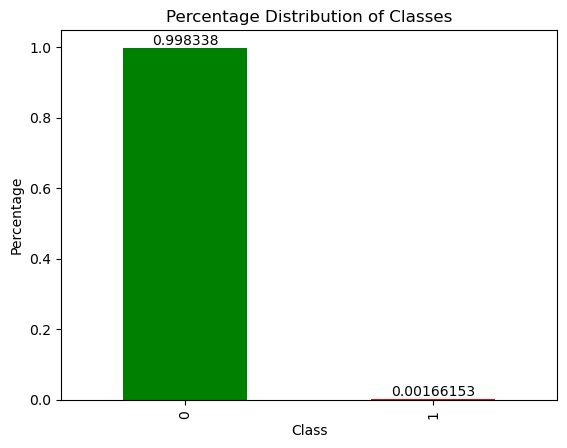

In [116]:
# Visulize the class distribution to show the imbalance
ax = data['Class'].value_counts(normalize = True).plot.bar(color = ['g', 'r'])
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Percentage Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

In [117]:
# Distribution of classes with time
data_fraud = data[data['Class'] == 1]
data_non_fraud = data[data['Class'] == 0]

In [118]:
# validation 2 dataframes
print(data_fraud.shape)
print(data_non_fraud.shape)

(83, 31)
(49871, 31)


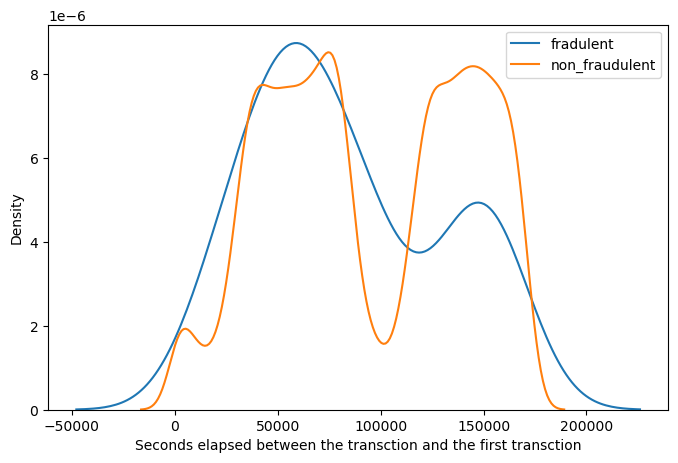

In [119]:
# distribution plot

plt.figure(figsize=(8, 5))
ax = sns.distplot(data_fraud['Time'], label='fradulent', hist=False)
ax = sns.distplot(data_non_fraud['Time'], label='non_fraudulent', hist=False)
ax.set(xlabel='Seconds elapsed between the transction and the first transction')
plt.legend(loc='best')
plt.show()

# Findings :
Can not find any specific pattern for the fraudulent and non-fraudulent transctions with respect to Time. Hence, we can drop the Time column.

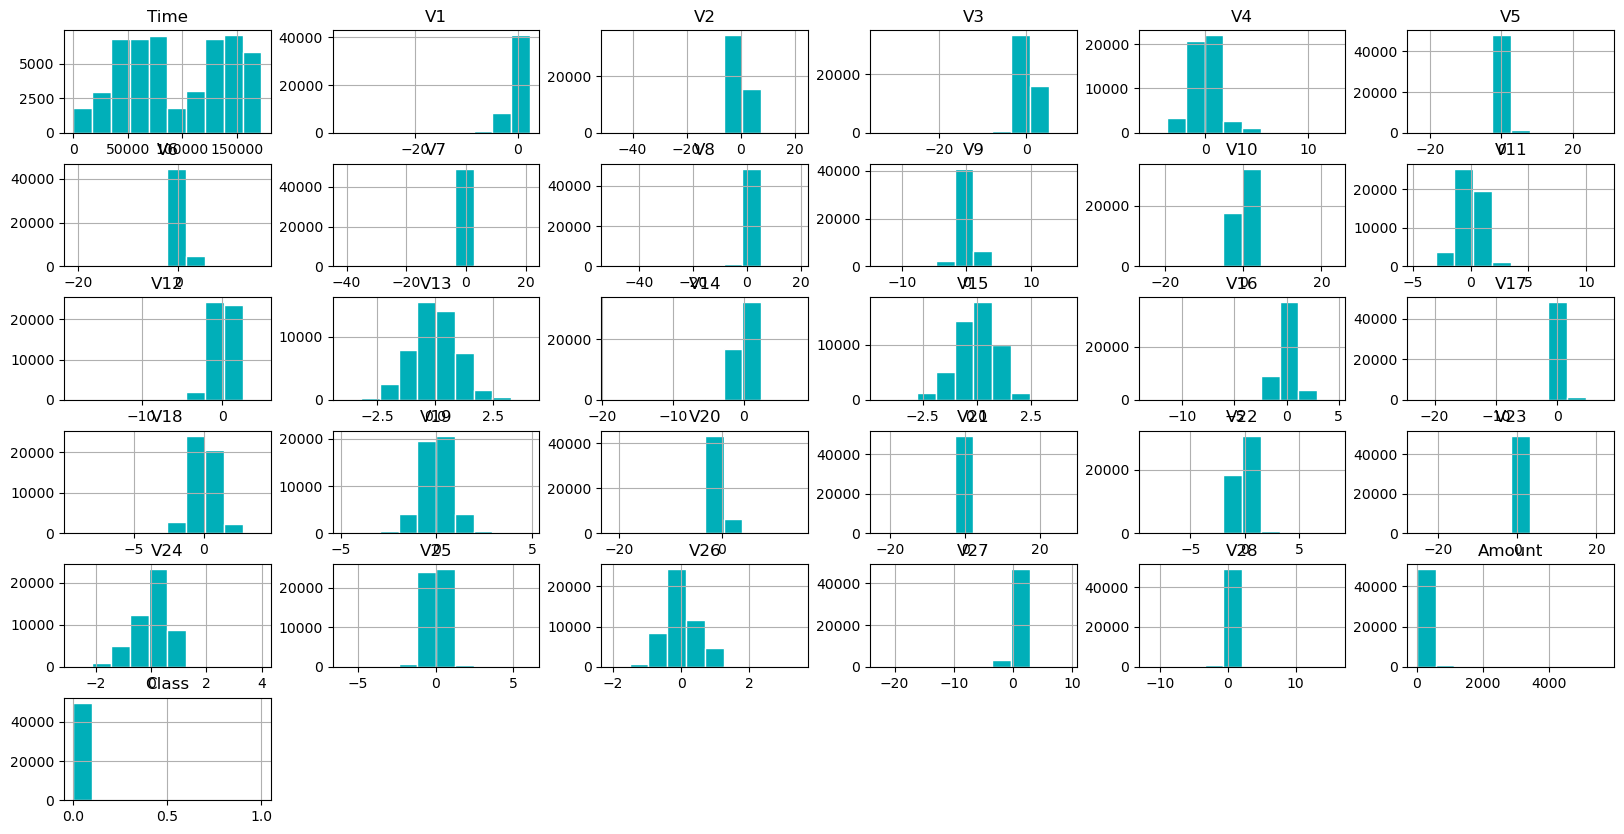

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,...,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000
mean,94956.694559,-0.000994,-0.000850,0.001906,0.001803,0.002831,0.001529,-0.003174,0.000438,-0.003118,...,-0.001827,0.004315,0.000902,0.000427,0.003935,0.001181,0.002233,-0.001442,87.430244,0.001662
std,47485.947118,1.958721,1.631368,1.524284,1.414673,1.352115,1.316773,1.207458,1.210733,1.104893,...,0.736061,0.727124,0.591668,0.607587,0.518001,0.481557,0.404789,0.324446,224.028636,0.040728
min,0.000000,-34.148234,-48.060856,-33.680984,-5.560118,-23.669726,-20.869626,-41.506796,-50.420090,-13.434066,...,-22.889347,-8.887017,-25.356744,-2.824849,-6.035054,-2.068561,-22.565679,-11.710896,0.000000,0.000000
25%,54354.250000,-0.919527,-0.603411,-0.893537,-0.847125,-0.697698,-0.766760,-0.559197,-0.209853,-0.646422,...,-0.228004,-0.541968,-0.164283,-0.354839,-0.314121,-0.324971,-0.070199,-0.052975,5.672500,0.000000
50%,84872.500000,0.019522,0.063720,0.179493,-0.019872,-0.048553,-0.272947,0.035928,0.021593,-0.053737,...,-0.029415,0.011074,-0.013122,0.042428,0.023361,-0.051472,0.001321,0.010609,22.050000,0.000000
75%,139371.750000,1.318485,0.799064,1.034028,0.741945,0.618025,0.407070,0.571267,0.324293,0.592003,...,0.187385,0.533437,0.146441,0.438988,0.350821,0.241460,0.089820,0.077982,77.600000,0.000000
max,172787.000000,2.439207,21.467203,9.382558,12.699542,29.016124,16.493227,21.437514,19.168327,15.594995,...,27.202839,8.361985,22.083545,3.990646,6.070850,3.463246,9.200883,15.942151,5680.000000,1.000000


In [120]:
# Distribution 
numbers = data.select_dtypes(['int64', 'float64']).columns.to_list()
data.hist(figsize=(20,10), edgecolor='white', color='#00afb9')
plt.show()
display(data[numbers].describe())

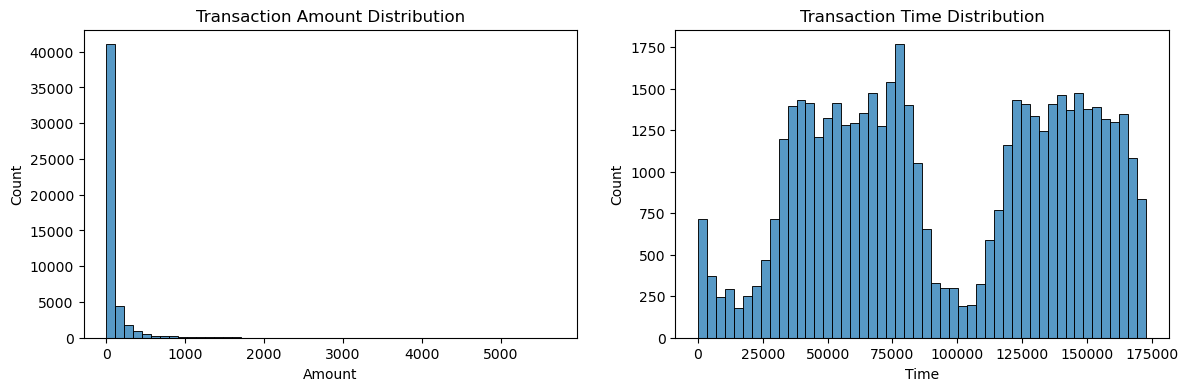

In [121]:
# Plot Amount and Time distributions
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.histplot(data['Amount'], bins=50, ax=ax[0])
ax[0].set_title('Transaction Amount Distribution')
sns.histplot(data['Time'], bins=50, ax=ax[1])
ax[1].set_title('Transaction Time Distribution')
plt.show()

In [122]:
# dropping the Time column
data.drop('Time', axis=1, inplace=True)

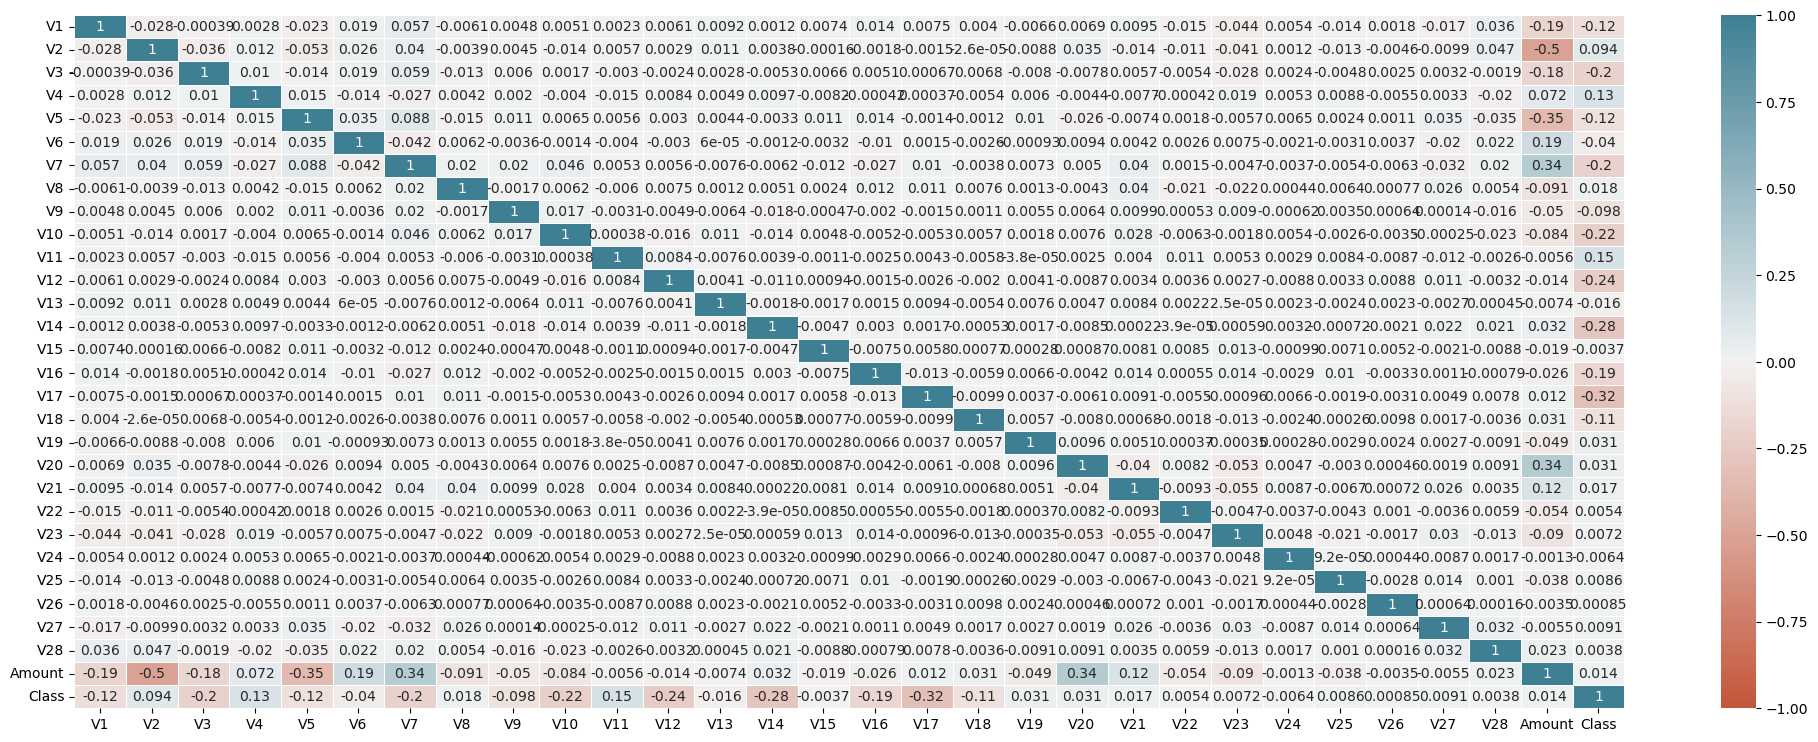

In [123]:
# Check correlation
fig, ax = plt.subplots(figsize=(25,9))
sns.heatmap(data[data.columns].corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=True, linewidths=.5)
plt.show()

In [124]:
data.shape

(49954, 30)

In [125]:
# Distribution of class with Amount
data[data.Class == 1].Amount.describe()

count      83.000000
mean      164.233855
std       311.803585
min         0.000000
25%         1.000000
50%         8.300000
75%       124.910000
max      1504.930000
Name: Amount, dtype: float64

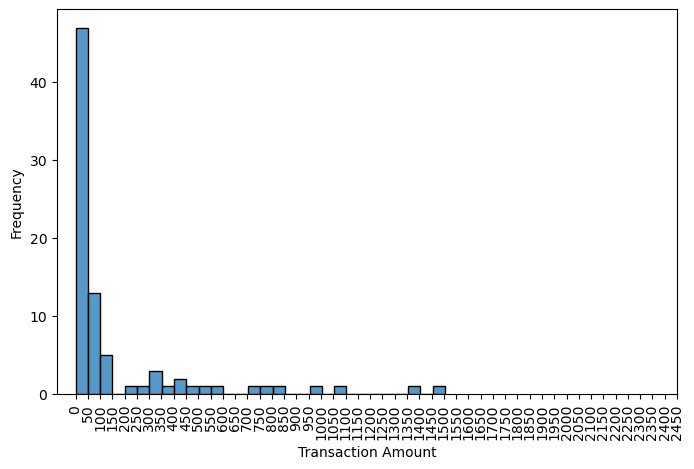

In [126]:
# distribution of Fradulent data
plt.figure(figsize=(8, 5))
sns.histplot(data_fraud['Amount'], binwidth=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.xticks(range(0, 2500, 50), rotation=90)
plt.show()

Most of the fradulent transactions are in the range of 0-50 dollars. Highest Fraud transaction was at between 2100-2150 dollars

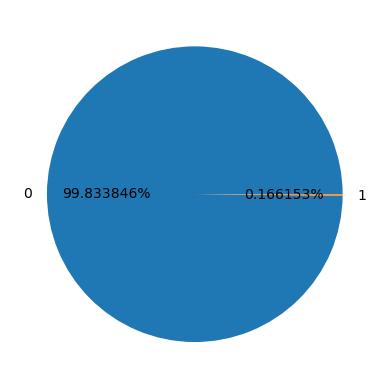

In [127]:
# Show the imbalanced data visually
outcome_counts = data["Class"].value_counts()
plt.pie(outcome_counts, labels = outcome_counts.index, autopct = "%f%%")
plt.show()

As we have seen that the data is heavily imbalanced, where only 0.16% transctions are fraudulent, which can affect when evaluating the model.


In [128]:
# Get all features in X without Class
X = data.drop(['Class'], axis=1)

In [129]:
# Get the target Class for prediction
y = data['Class']

In [130]:
# Validate both X and y

In [131]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89


In [132]:
y.head()

43428     1
49906     0
29474     0
276481    0
278846    0
Name: Class, dtype: int64

## Two data balancing techniqes are applied and tested.

In [133]:
# 1. Balancing with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("\nAfter SMOTE balancing:")
print(pd.Series(y_smote).value_counts())


After SMOTE balancing:
Class
1    49871
0    49871
Name: count, dtype: int64


In [134]:
# 2. Alternative: Random UnderSampling (for future analysis)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
print("\nAfter Random UnderSampling:")
print(pd.Series(y_rus).value_counts())



After Random UnderSampling:
Class
0    83
1    83
Name: count, dtype: int64


In [135]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_smote_scaled = scaler.fit_transform(X_smote) # SMOTE
X_rus_scaled = scaler.fit_transform(X_rus) # RandomUnderSampler

# Training the data balanced through SMOTE

In [136]:
# Train and test the data using SMOTE data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_smote_scaled, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)


In [137]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [138]:
# Get the best parameter and score for all the models for traning
best_model, best_params, best_score = fit_best_models(X_train, y_train)


In [139]:
print("Models:", best_model)

Models: {'logreg': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=10))]), 'rf': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(n_estimators=50, random_state=42))]), 'dt': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])}


In [140]:
print("Parameter:", best_params)

Parameter: {'logreg': {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}, 'rf': {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}, 'dt': {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 2}}


In [141]:
print("Scores:", best_score)

Scores: {'logreg': 0.9680047256701261, 'rf': 0.9998746772939533, 'dt': 0.9989347507160554}


Based on the baseline model, RandomForestClassifier has performed the best.

In [142]:
# Using the best parameters from the previous step
# Predict if a transaction is fraud or not using the below 3 models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC

models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=10, solver='lbfgs', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=42),
    'DecisionTree': DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
}


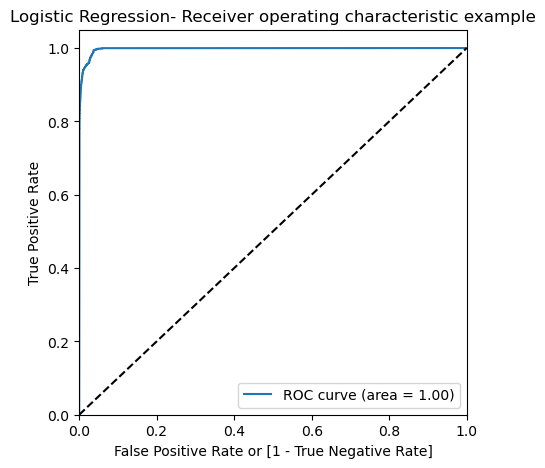

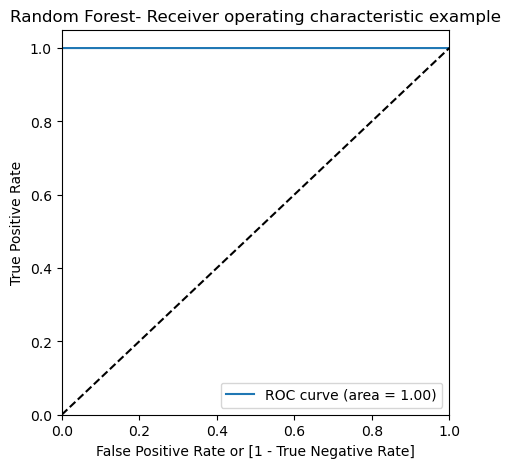

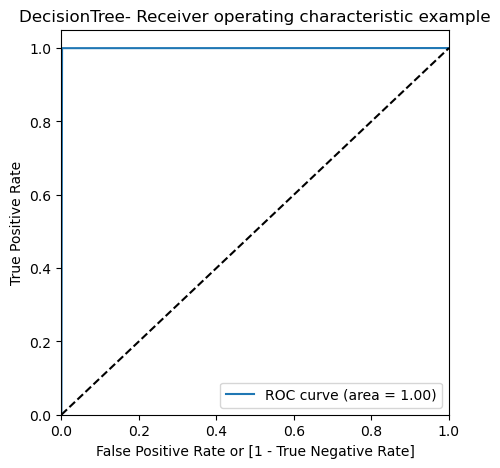

In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

results = []
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else roc_auc_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })
    
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    draw_roc(name, y_test, y_proba)

In [148]:
# Compare the model accuracy by creating a dataframe for the model report
results_df = pd.DataFrame(results)
print("\nModel Comparison (SMOTE):")
print(results_df)


Model Comparison (SMOTE):
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.967617   0.976502  0.958292  0.967311  0.997549
1        Random Forest  0.999699   0.999399  1.000000  0.999699  0.999999
2         DecisionTree  0.998997   0.998298  0.999699  0.998998  0.998997


In [87]:
# Tune the model (Best model: Random Forest)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("\nBest Random Forest parameters:", grid.best_params_)
print("Best F1 Score from GridSearchCV:", grid.best_score_)



Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score from GridSearchCV: 0.9998496381916336


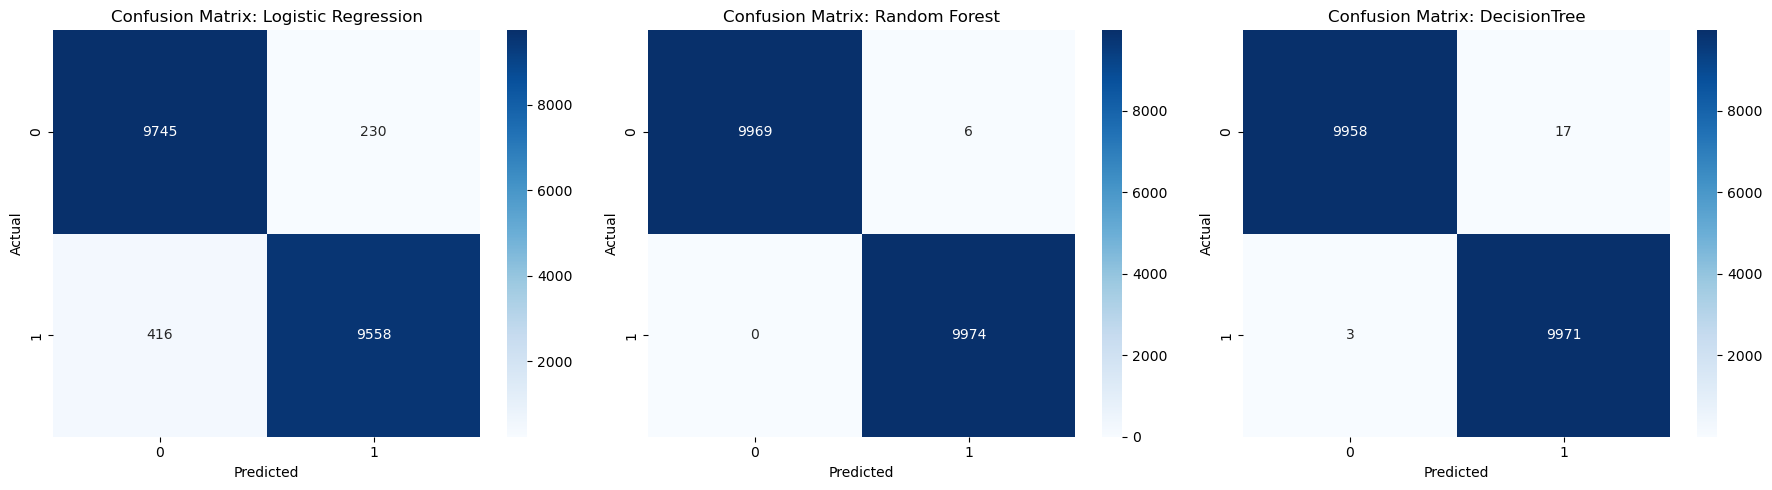

In [88]:

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Training the data balanced through RandomUnderSampler

In [89]:
# Try other balancing techniques for future analysis
# Repeat the same modeling steps with X_rus_scaled, y_rus

# Future analysis
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus_scaled, y_rus, test_size=0.2, random_state=42, stratify=y_rus)


In [90]:
# Get the best parameter and score for all the models for traning
best_model, best_params, best_score = fit_best_models(X_train_rus, y_train_rus)


In [91]:
print("Models:", best_model)

Models: {'logreg': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=10))]), 'rf': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))]), 'dt': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier(random_state=42))])}


In [92]:
print("Parameter:", best_params)

Parameter: {'logreg': {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}, 'rf': {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}, 'dt': {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 2}}


In [93]:
print("Scores:", best_score)

Scores: {'logreg': 0.9324786324786324, 'rf': 0.9549857549857549, 'dt': 0.9019943019943021}


In [94]:
# Use the best parameter from the above steps to train the model
models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=10, solver='lbfgs', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, min_samples_split=2, random_state=42),
    'DecisionTree': DecisionTreeClassifier(criterion='gini', min_samples_split=2, random_state=42)
}

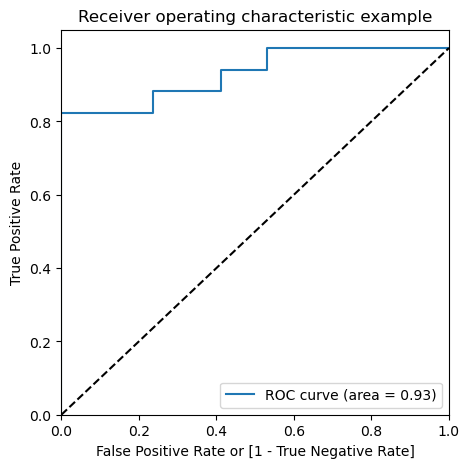

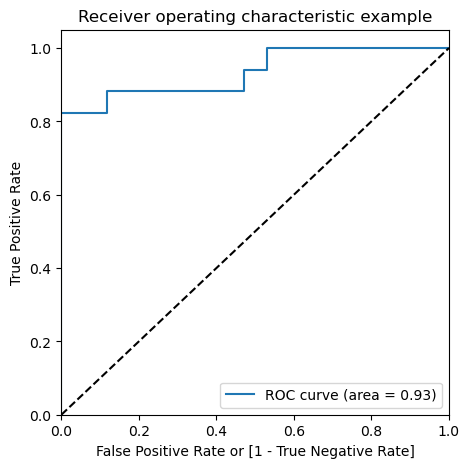

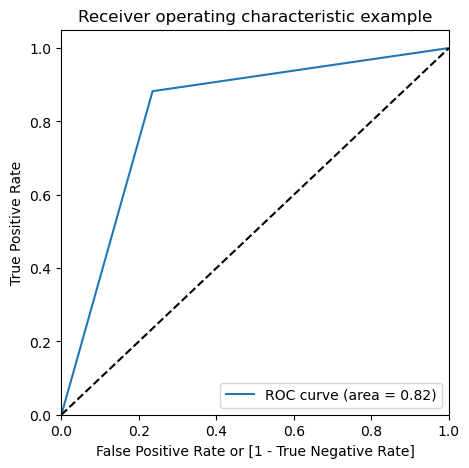

In [102]:
results = []
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test_rus)
    y_proba = model.predict_proba(X_test_rus)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test_rus, y_pred)
    prec = precision_score(y_test_rus, y_pred)
    rec = recall_score(y_test_rus, y_pred)
    f1 = f1_score(y_test_rus, y_pred)
    roc_auc = roc_auc_score(y_test_rus, y_proba) if y_proba is not None else roc_auc_score(y_test_rus, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })
    
    conf_matrices[name] = confusion_matrix(y_test_rus, y_pred)
    draw_roc(y_test_rus, y_proba)

In [97]:
# Compare the model accuracy by creating a dataframe for the model report
results_df = pd.DataFrame(results)
print("\nModel Comparison (RandomUnderSampler):")
print(results_df)


Model Comparison (RandomUnderSampler):
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.882353   0.933333  0.823529  0.875000  0.930796
1        Random Forest  0.911765   1.000000  0.823529  0.903226  0.934256
2         DecisionTree  0.823529   0.789474  0.882353  0.833333  0.823529


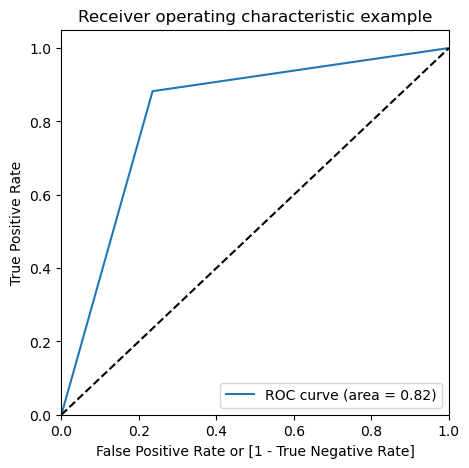

0.8235294117647058

In [101]:
# Plot the ROC curve
from sklearn import metrics
draw_roc(y_test_rus, y_proba)

In [98]:
# Tune the model (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_rus, y_train_rus)
print("\nBest Random Forest parameters:", grid.best_params_)
print("Best F1 Score from GridSearchCV:", grid.best_score_)


Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score from GridSearchCV: 0.9512195121951219


Summary of Steps:
1. Read the data
2. EDA: Info, describe, class distribution, plots
3. Check imbalance: Print class counts
4. Balance data: SMOTE (over-sampling) and RandomUnderSampler (under-sampling)
5. Scale data: StandardScaler
6. Train/test split
7. Modeling: Logistic Regression, Random Forest, SVM
8. Compare models: DataFrame with metrics
9. Tune model: GridSearchCV for Random Forest
10. Plot confusion matrices
11. Other balancing techniques: Code for under-sampling included for future analysis


### Feature scaling of the Amount column as other columns are scaled by PCA transformation already.

In [167]:
# Instantiate the Scaler and scale the Amount
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
257334,2.139297,-2.379957,-0.588094,-2.116887,-0.151810,4.930636,-3.133495,1.408309,0.431508,1.189920,...,-0.379746,-0.073778,0.629693,0.241327,0.738886,-0.314844,0.044060,0.139812,-0.034152,-0.308400
118498,-2.150992,0.447565,0.584405,1.181052,0.180772,-1.200828,-0.106578,0.771604,-1.441208,-0.481802,...,0.028937,-0.066225,-0.869480,-0.041398,0.501689,-0.198083,-0.732049,-0.234089,-0.221309,-0.363961
120679,-6.000510,-5.868708,-1.210423,2.234168,-0.925608,0.019870,0.012067,0.910109,-0.905567,0.233812,...,0.545803,-0.132715,-0.755490,0.460192,-0.747164,-0.243348,-0.205593,0.915416,-1.136679,1.876398
163000,2.021325,-0.535640,-0.416146,-0.124310,-0.178832,0.918878,-1.042599,0.318182,1.072180,0.119271,...,-0.078728,0.020950,0.209552,0.220896,-0.311931,-0.459092,0.495448,-0.012725,-0.051766,-0.359922
171948,0.149536,0.807852,-0.590906,-0.509802,1.145394,-1.116329,0.935687,-0.234237,0.014499,-1.110721,...,-0.122272,0.220651,0.679815,-0.349294,-0.734172,0.185243,-0.114120,0.027129,0.015322,-0.344877


In [168]:
# transform the test set
X_test['Amount'] = scaler.transform(X_test[['Amount']])
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
139330,-1.684059,1.500809,0.759888,0.550576,0.232439,-0.043998,0.626440,-0.004514,-0.004855,1.376058,...,0.252636,0.099876,0.702279,-0.194992,0.034693,-0.271951,-0.402507,-0.359649,-0.093177,-0.283875
86361,-0.712760,0.946364,1.613294,-0.057937,0.307252,0.033698,0.842808,-0.082649,-0.286508,-0.691974,...,0.043267,-0.209533,-0.489587,-0.374907,-0.405319,0.492170,0.339188,-0.107684,0.052013,-0.234826
94117,1.194627,0.202019,0.148443,0.456065,-0.024289,-0.105957,-0.146632,0.140367,-0.109165,-0.137806,...,-0.134548,-0.237956,-0.716717,0.114452,-0.366347,0.135195,0.129319,-0.014949,0.012339,-0.360375
123803,1.191219,-0.686249,0.413138,0.261424,-0.634744,0.624022,-0.717510,0.123673,-0.737618,0.811951,...,-0.297845,-0.214390,-0.138765,-0.283669,-0.835391,0.646958,-0.177545,0.063255,0.026668,-0.019874
126884,0.807040,-1.845157,1.160044,-0.078988,-1.973917,0.492741,-1.211037,0.286344,0.606206,0.173870,...,0.443070,0.253705,0.462592,-0.229476,0.129784,0.251871,-0.111874,0.038918,0.063682,0.666405


### Check for Skewness

In [169]:
# listing all columns
cols = X_train.columns
cols

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [170]:
print(data.skew())

V1        -3.273271
V2        -4.695162
V3        -2.151984
V4         0.671504
V5        -2.414079
V6         1.829880
V7         2.890271
V8        -8.310970
V9         0.537663
V10        1.252967
V11        0.344074
V12       -2.199008
V13        0.064293
V14       -1.918804
V15       -0.309659
V16       -1.051161
V17       -3.690497
V18       -0.248661
V19        0.108312
V20       -2.043121
V21        2.820033
V22       -0.182330
V23       -5.867221
V24       -0.552129
V25       -0.415744
V26        0.580292
V27       -0.753804
V28       11.555115
Amount    16.978803
Class     24.430545
dtype: float64


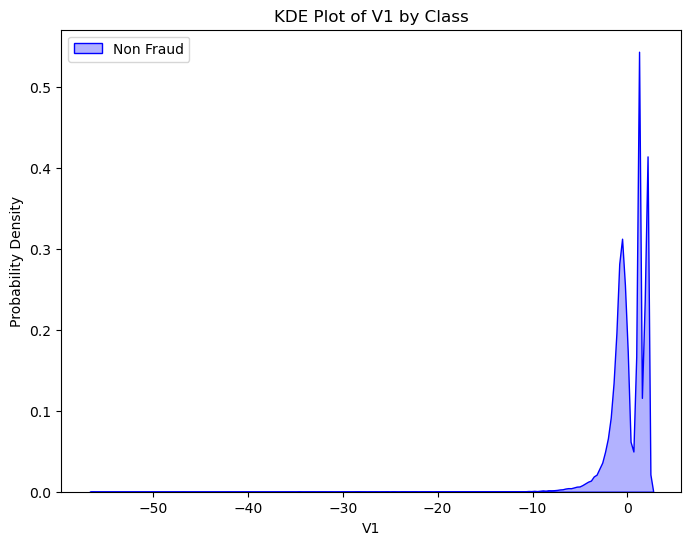

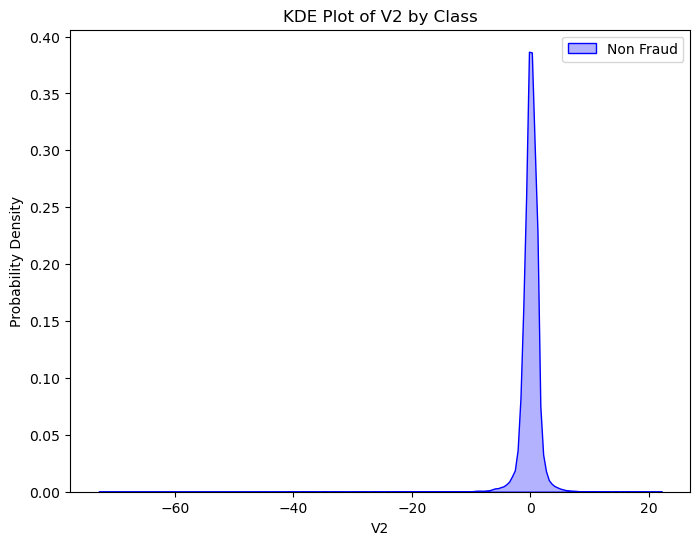

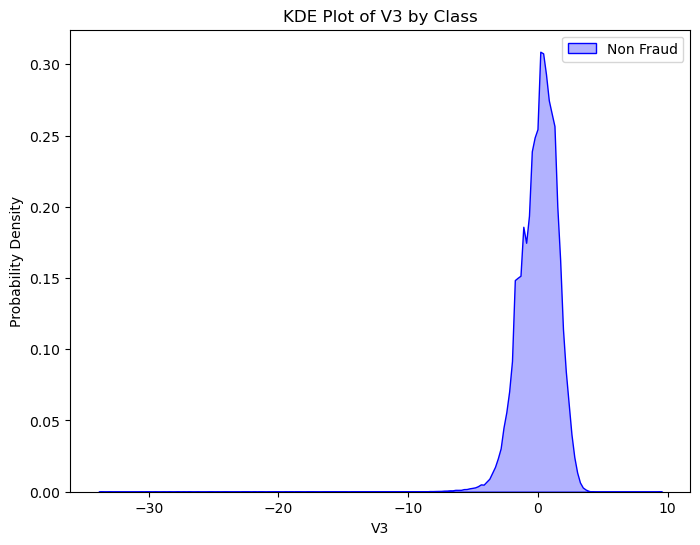

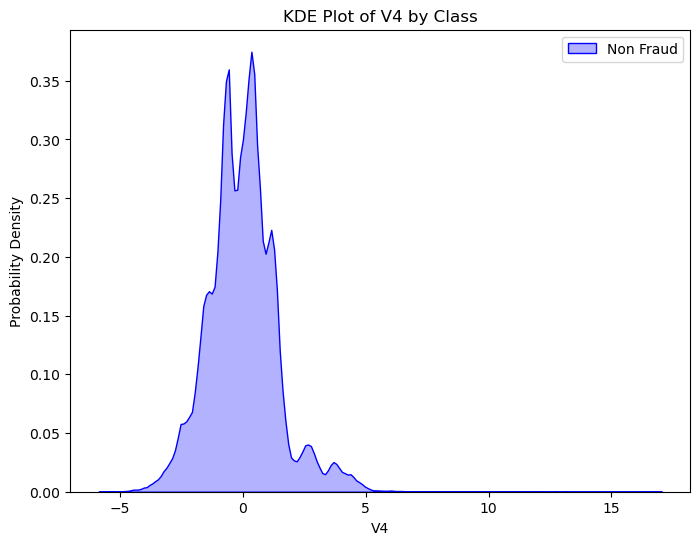

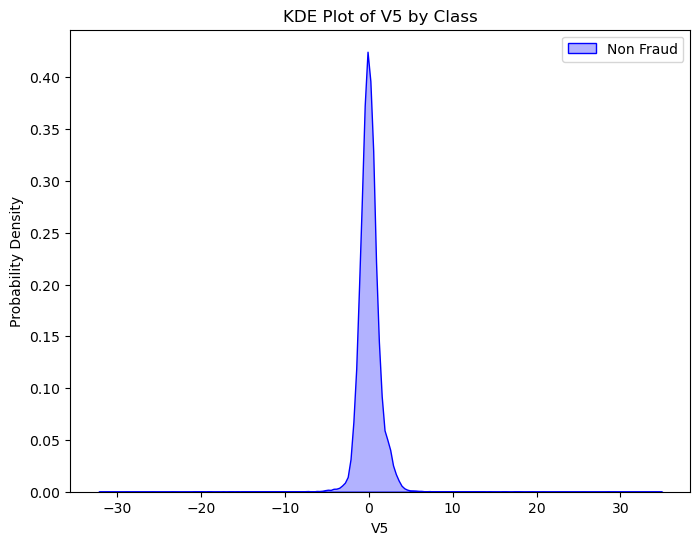

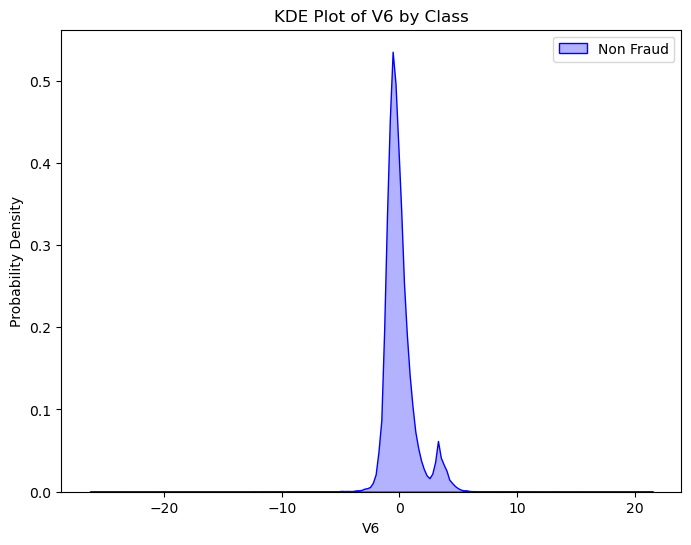

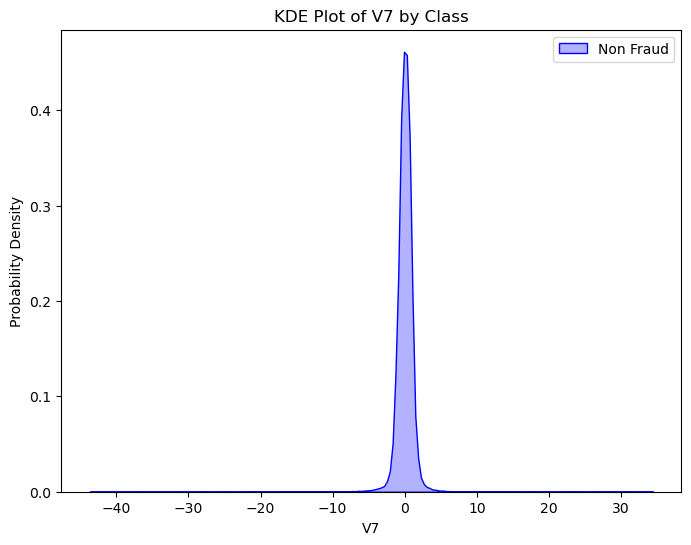

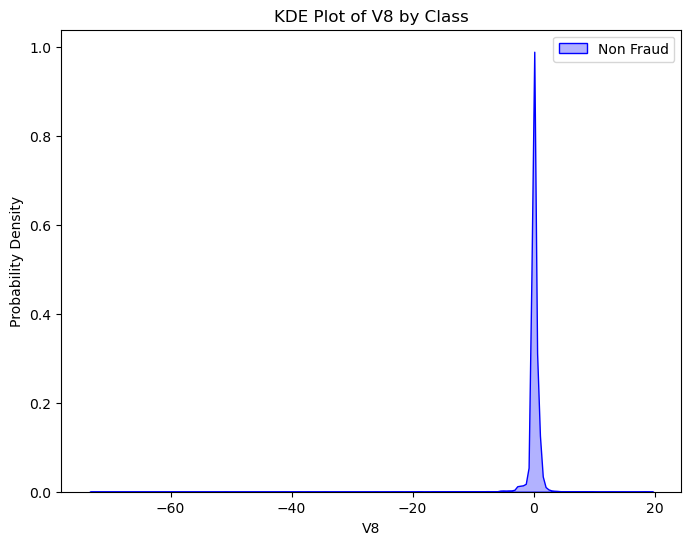

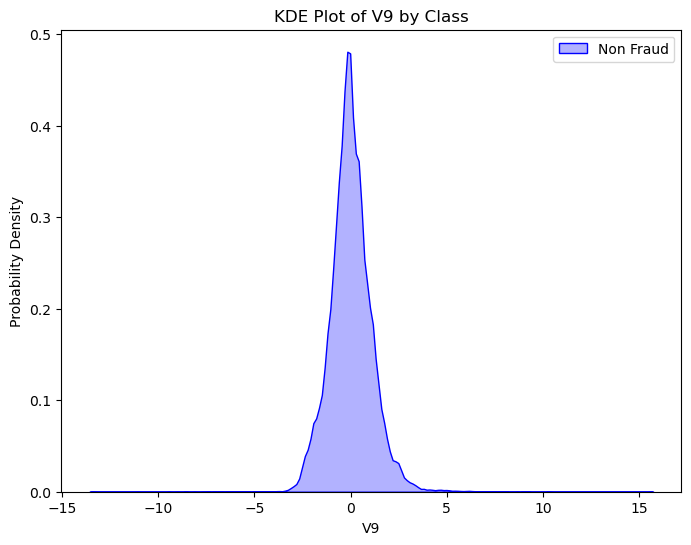

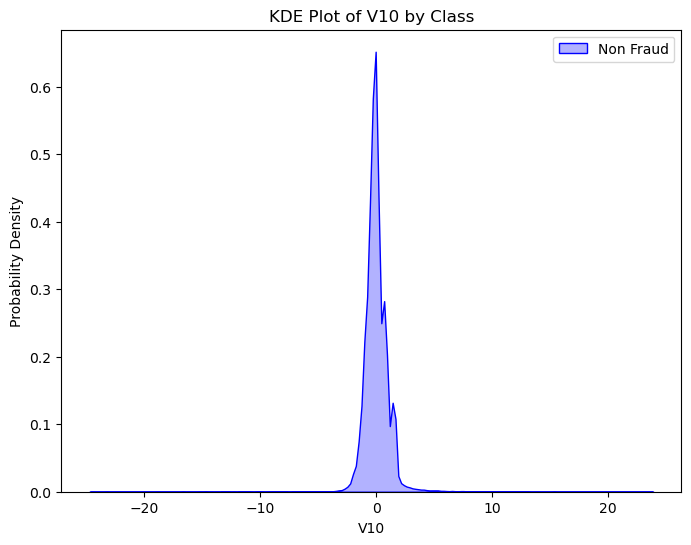

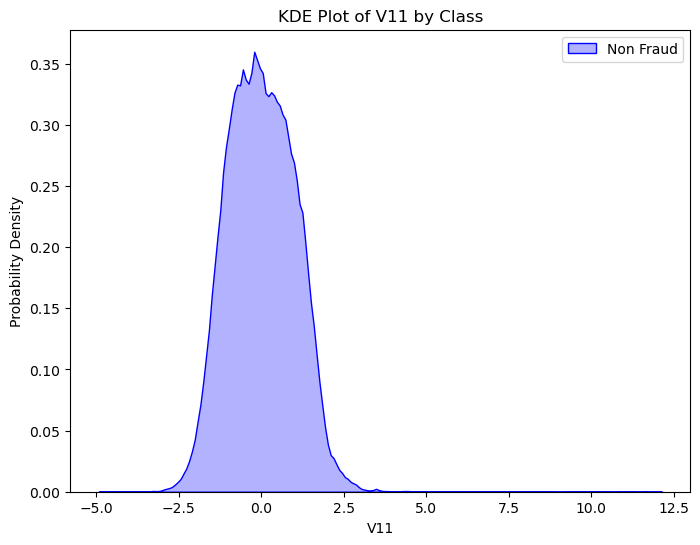

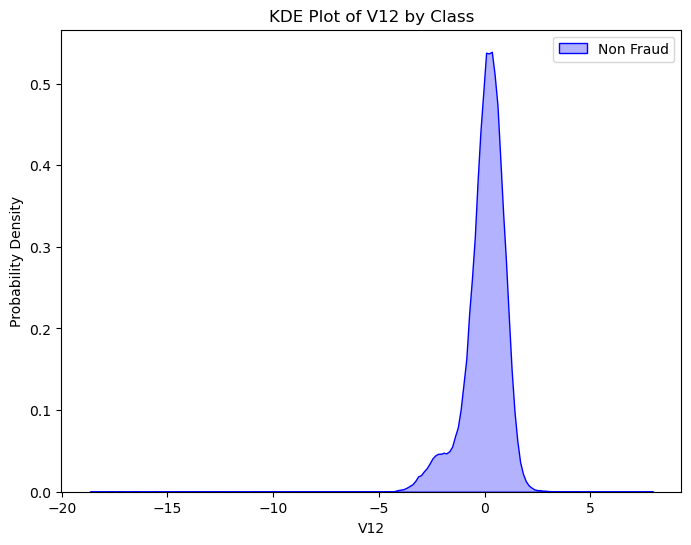

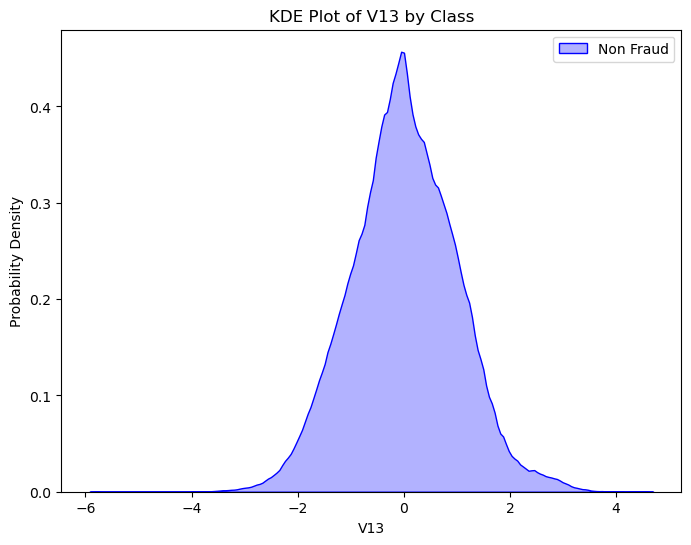

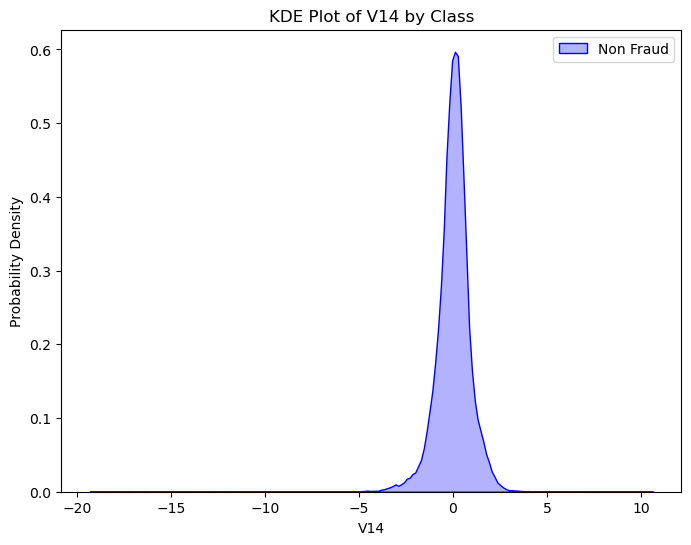

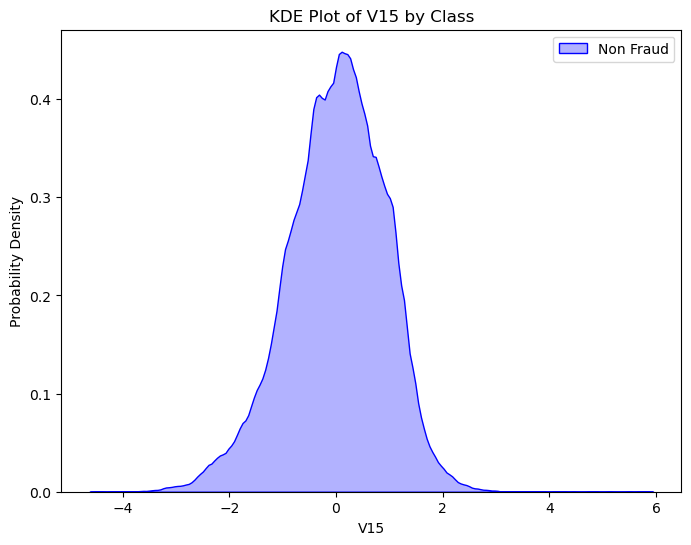

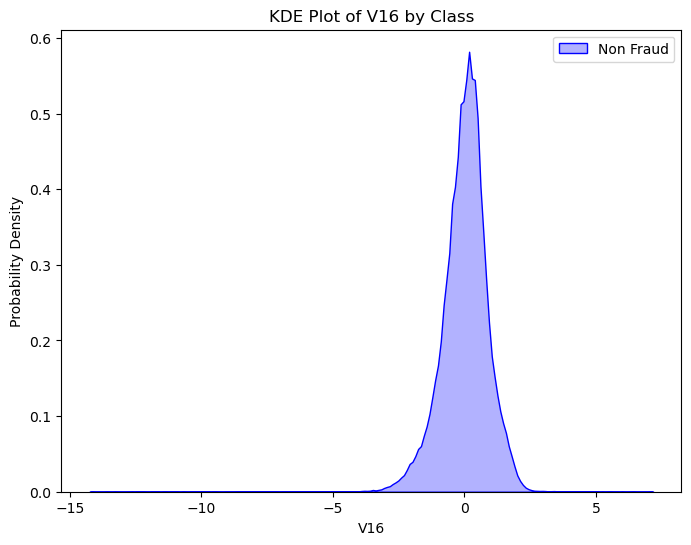

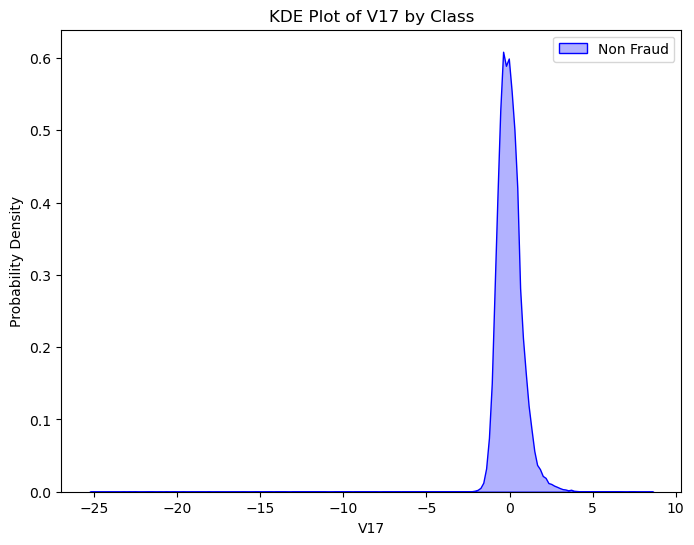

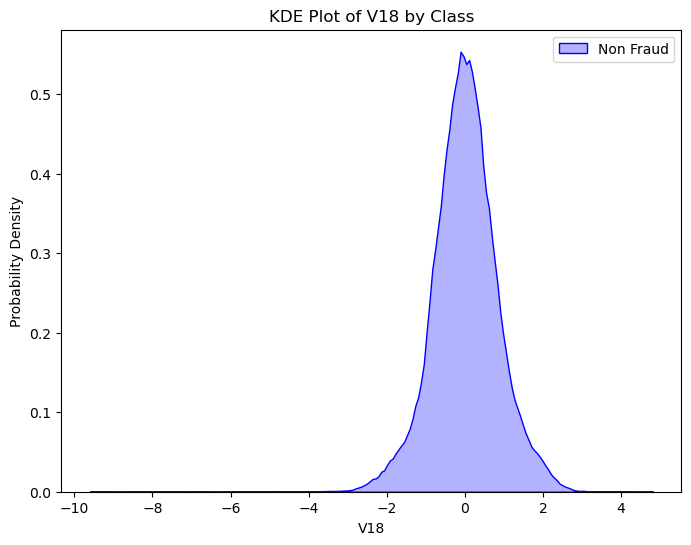

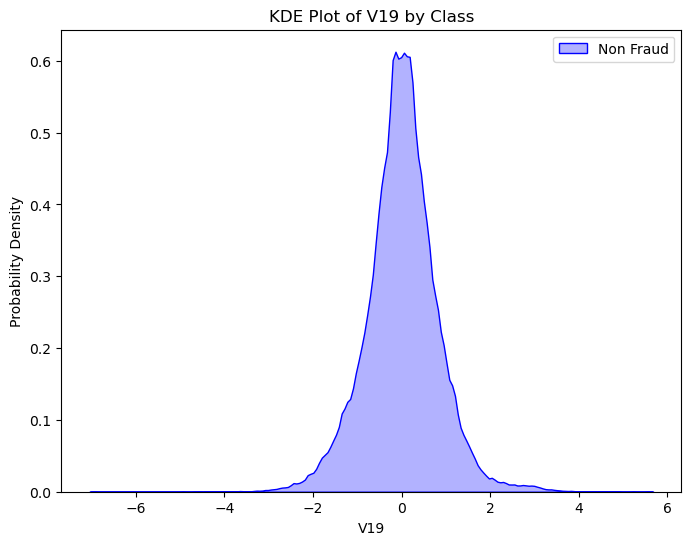

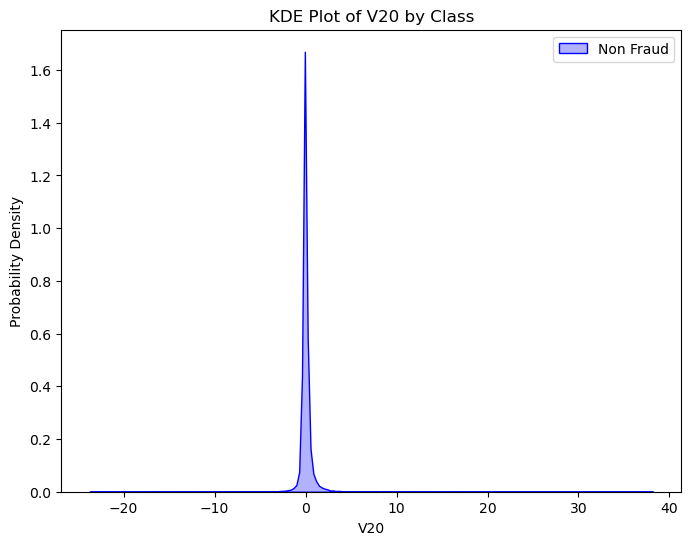

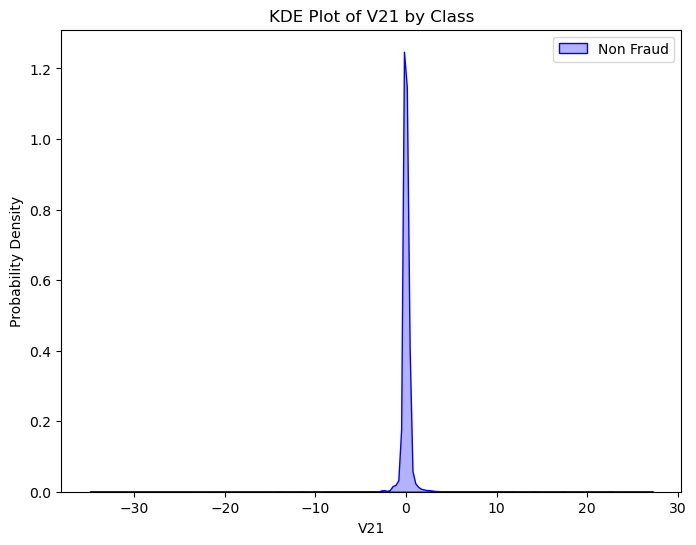

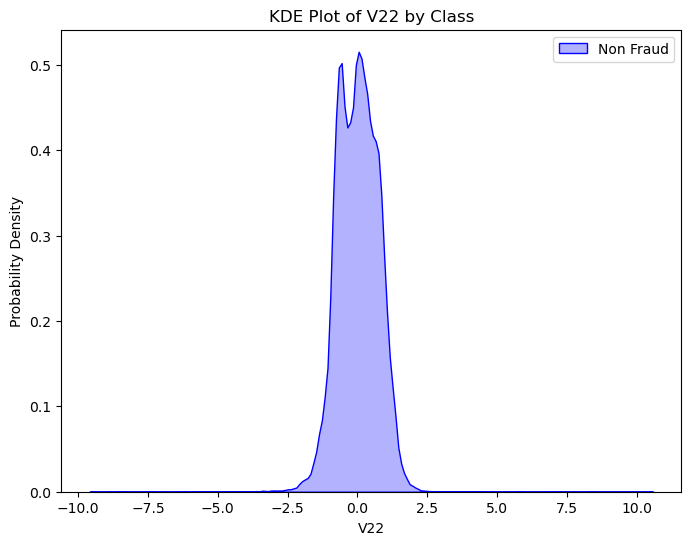

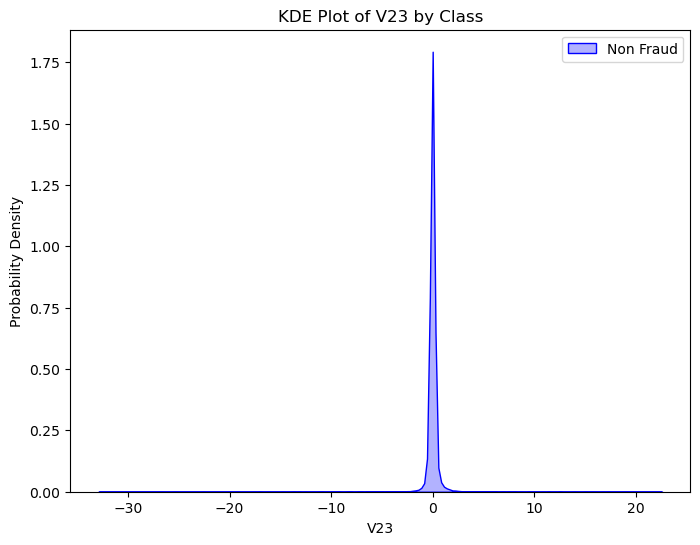

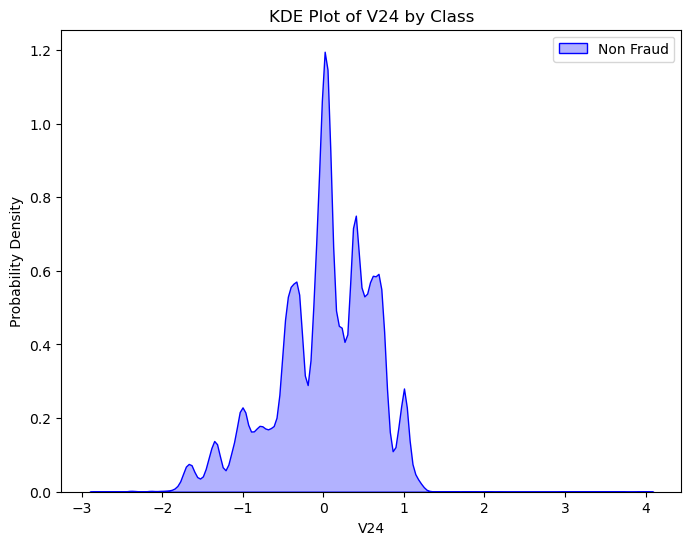

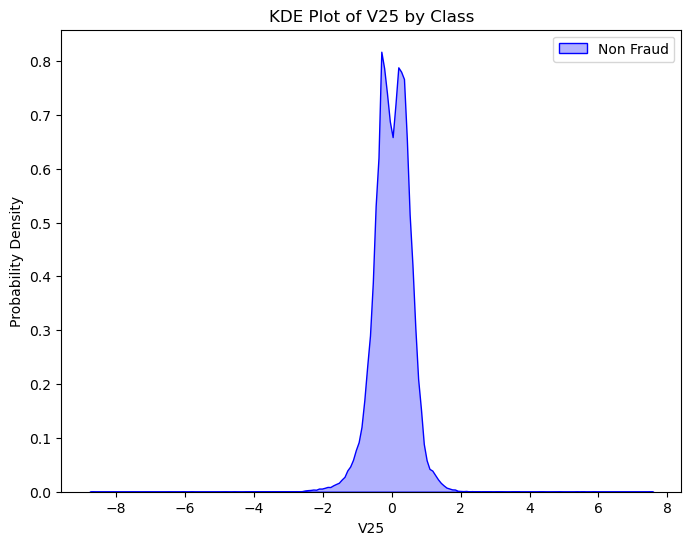

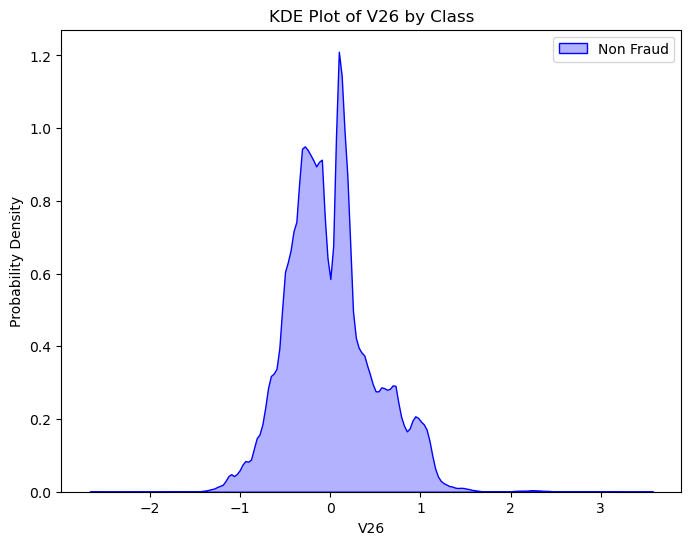

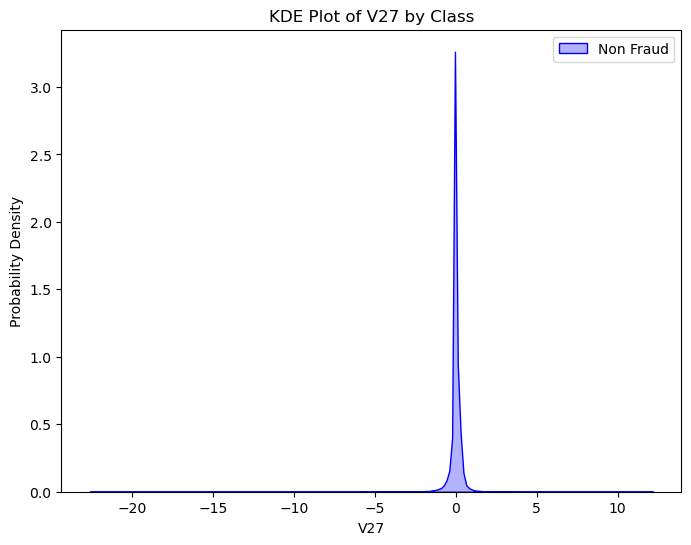

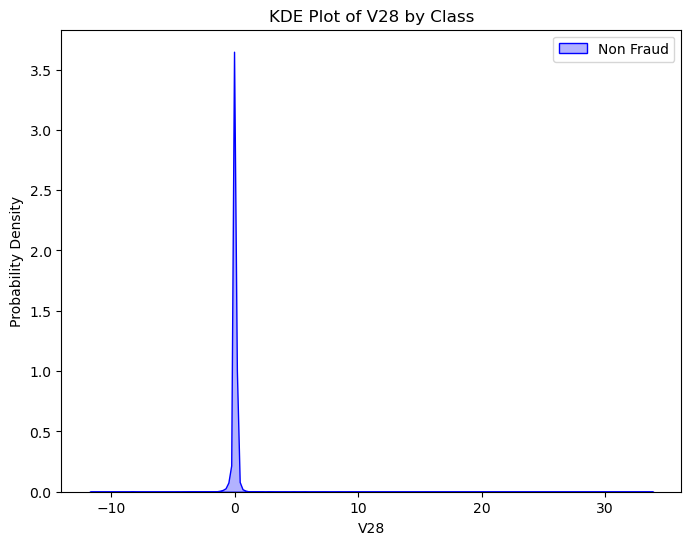

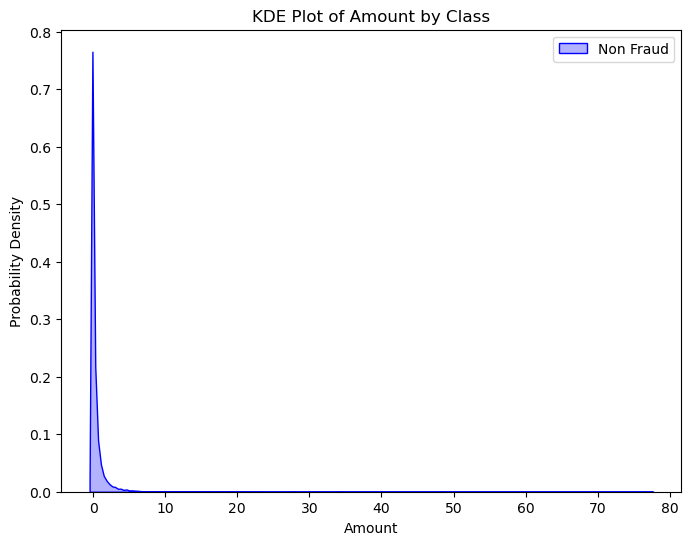

In [172]:
# Function to display skweness in the data visually
def plot_kde_all_features(data, columns,):
       
    for column in columns:
        plt.figure(figsize=(8, 6))
        # Plot KDE for Class=0 (Non-Fraud)
        sns.kdeplot(data=data, x=column, 
                    color='b', label='Non Fraud', fill=True, alpha=0.3, bw_adjust=0.5)
        plt.xlabel(column)
        plt.ylabel('Probability Density')
        plt.title(f'KDE Plot of {column} by Class')
        plt.legend()
        plt.show()
        
# Select numerical features (exclude 'Class')
features = data.columns.drop('Class')

# Plot KDEs for all features
plot_kde_all_features(X_train, X_train.columns)

### Address skweness with PowerTransformer

In [105]:
# Importing PowerTransformer
from sklearn.preprocessing import PowerTransformer 

# Instantiate the powertransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)

# Fit and transform the PT on training data
X_train[cols] = pt.fit_transform(X_train)

In [109]:
# Transform the test set
X_test = pt.transform(X_test)

In [ ]:
pt.tr

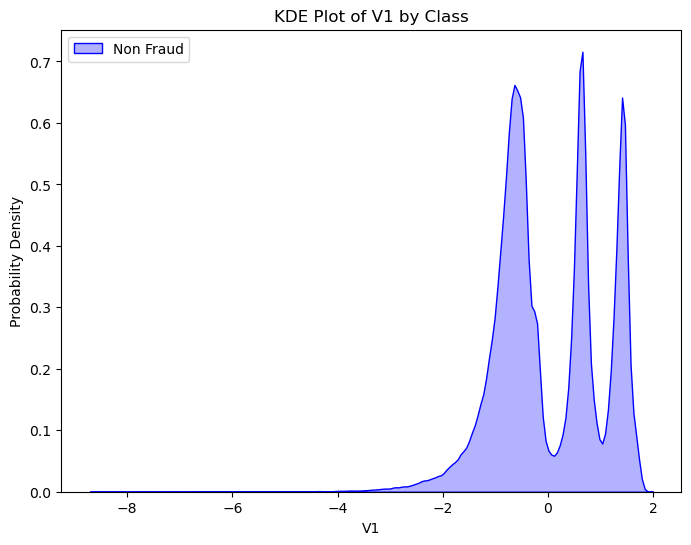

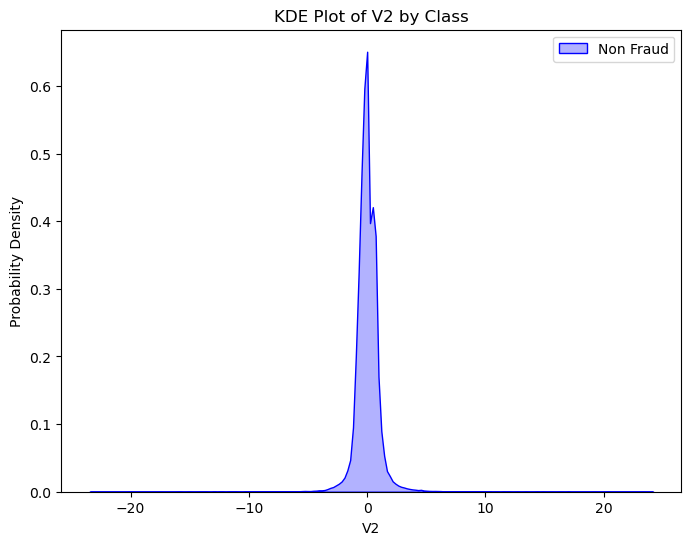

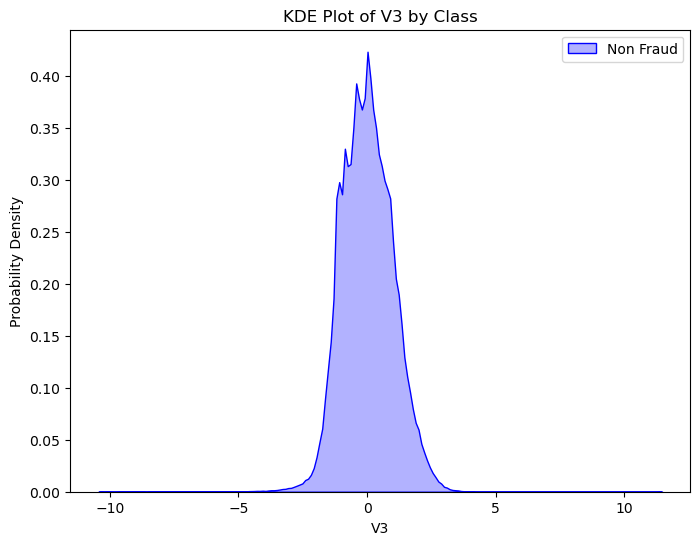

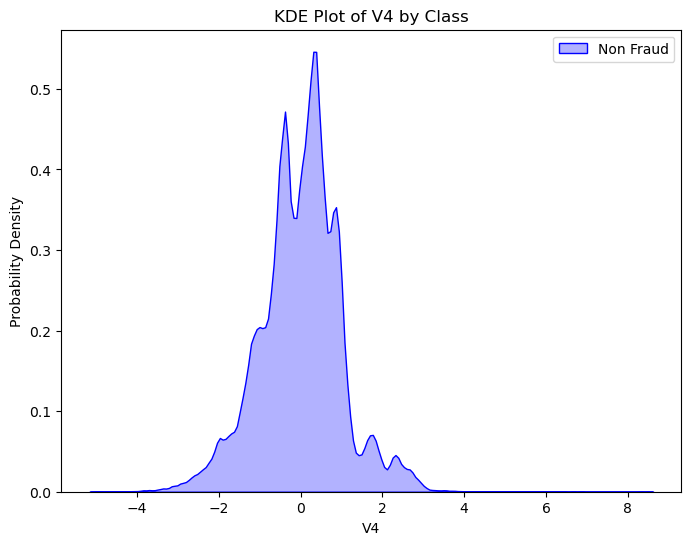

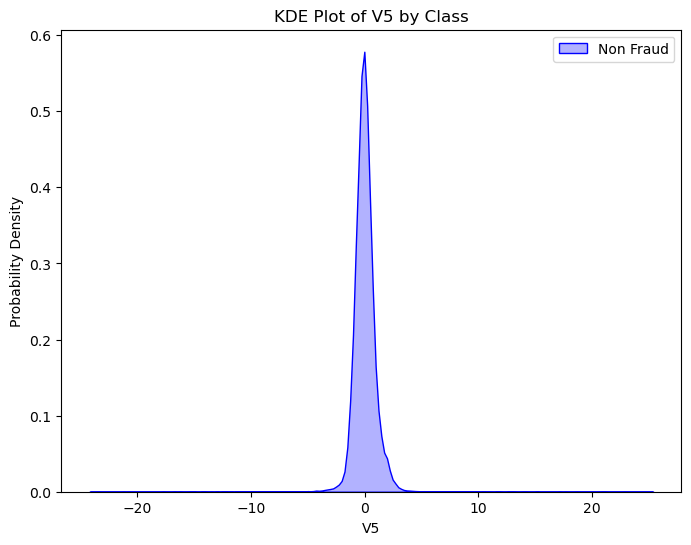

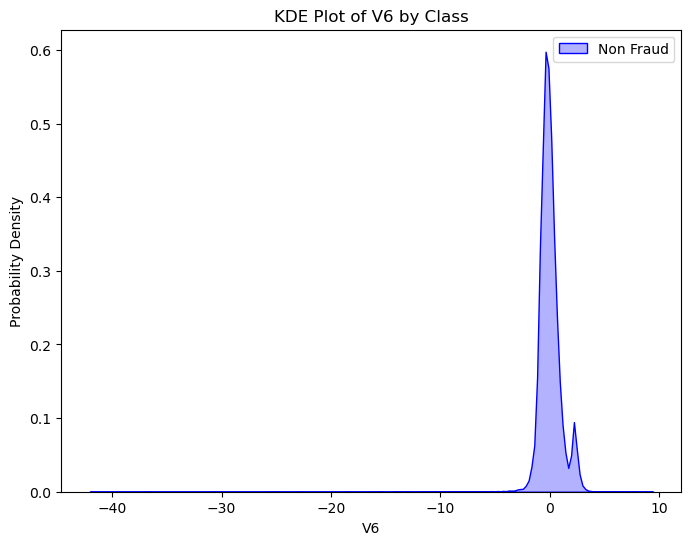

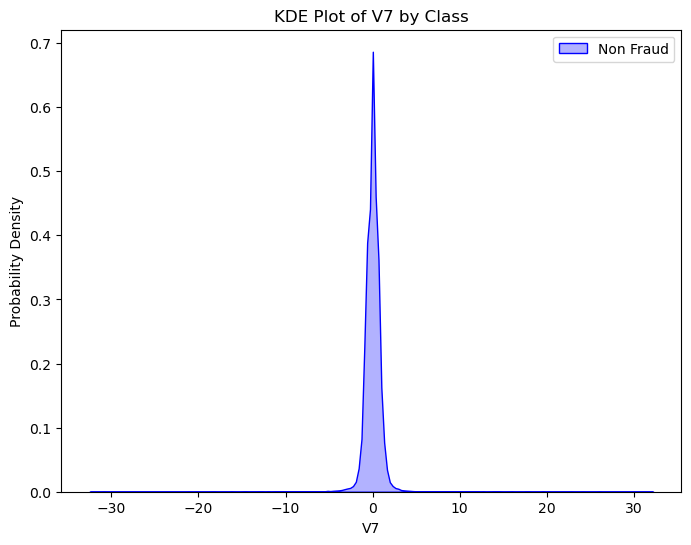

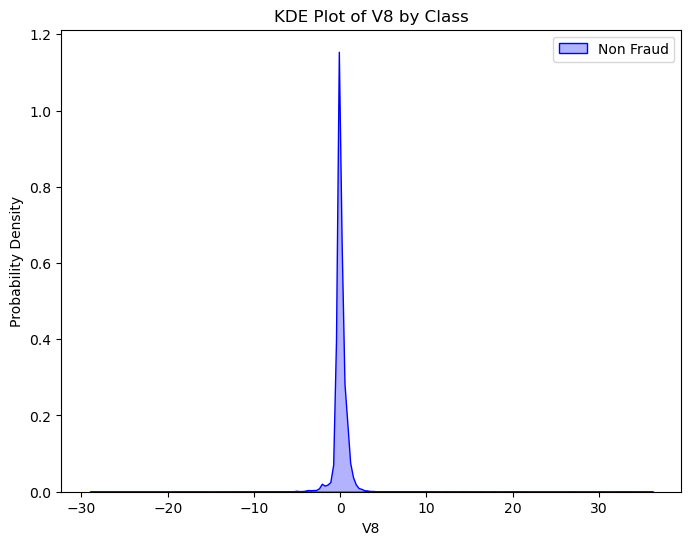

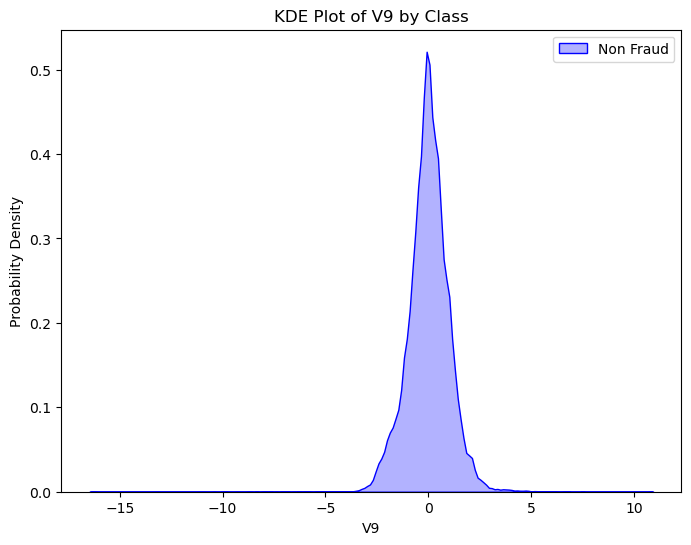

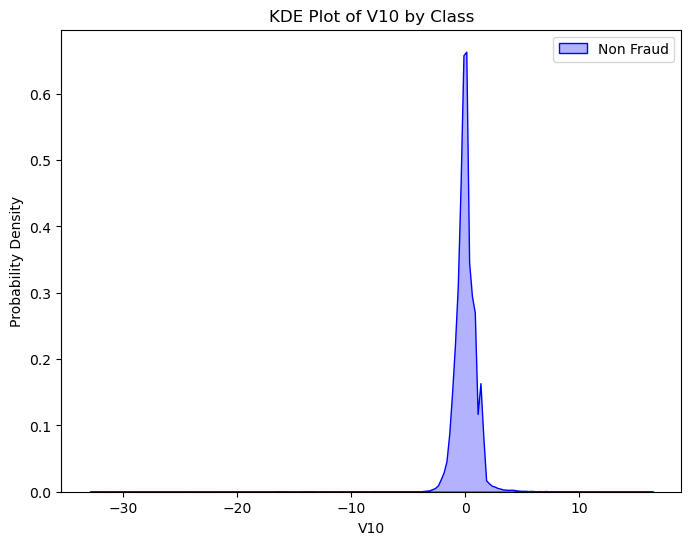

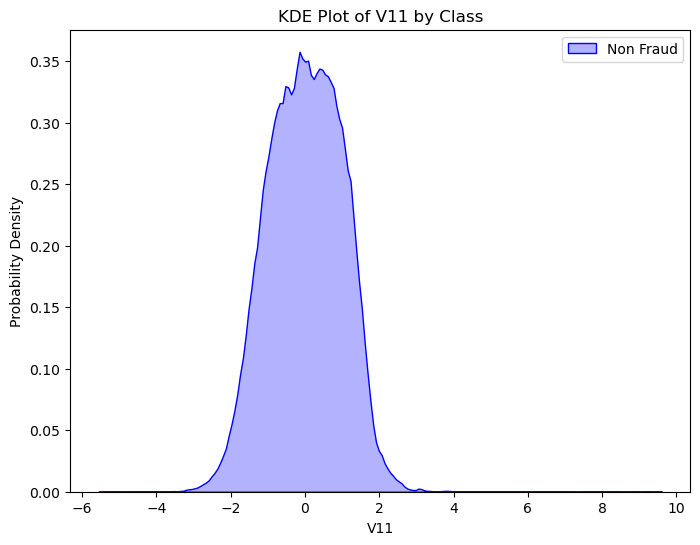

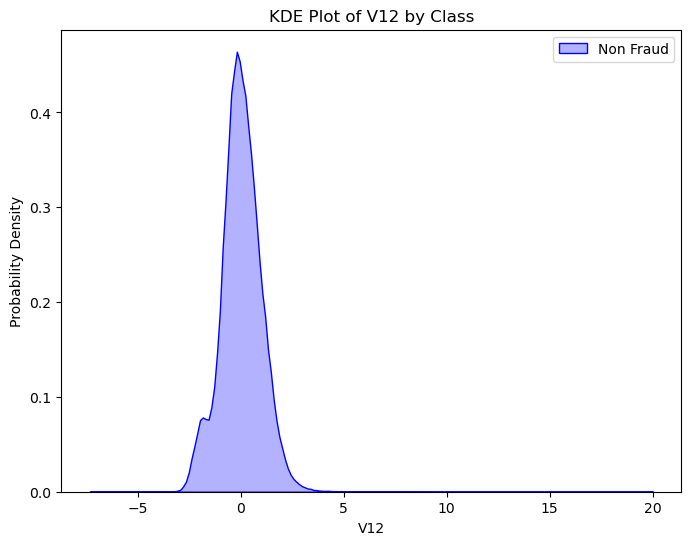

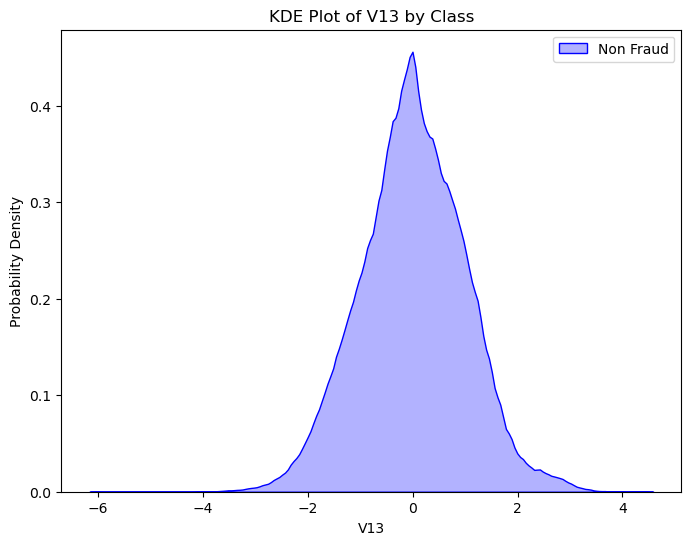

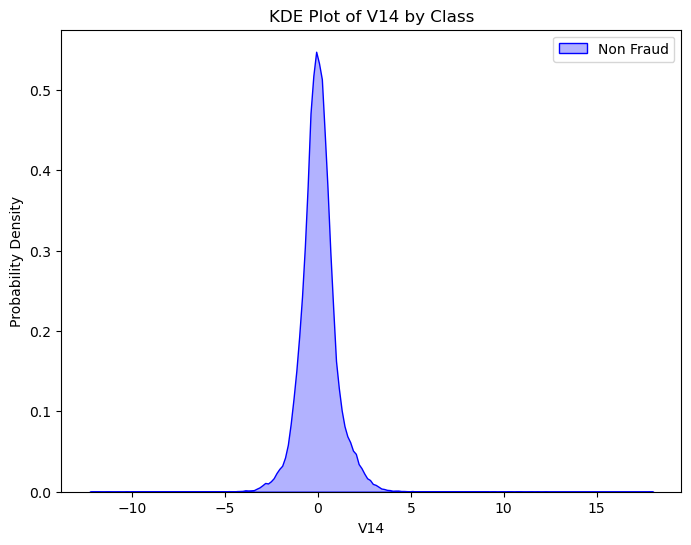

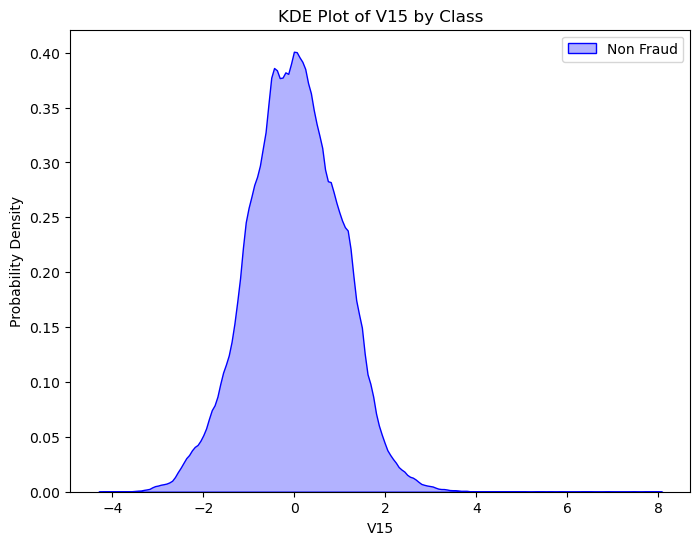

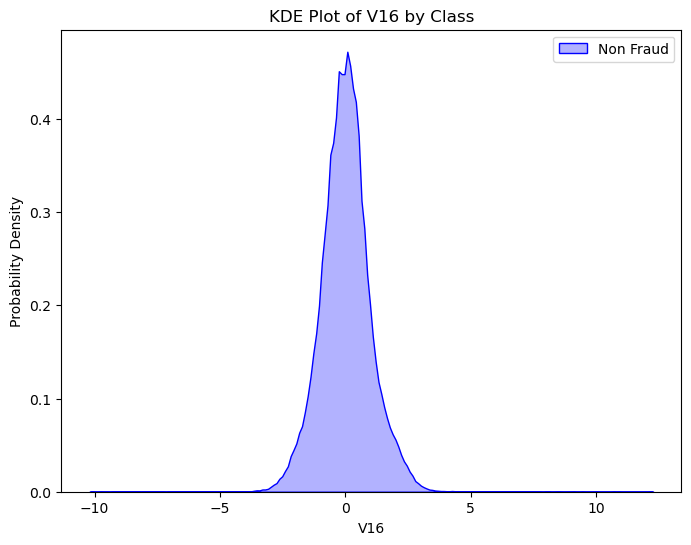

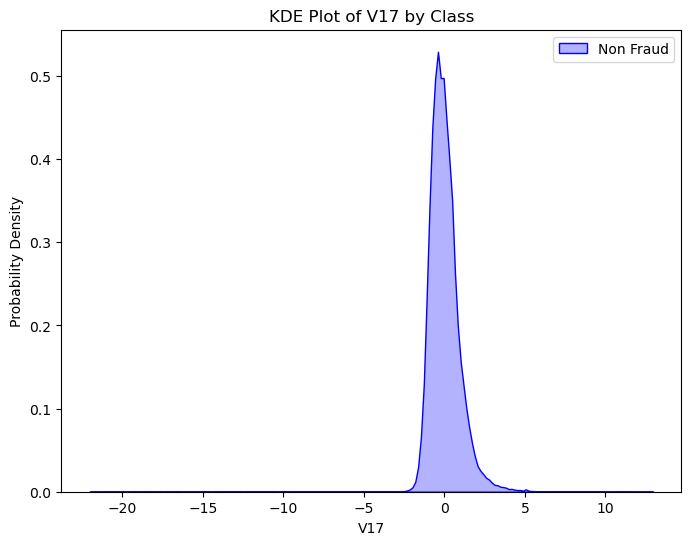

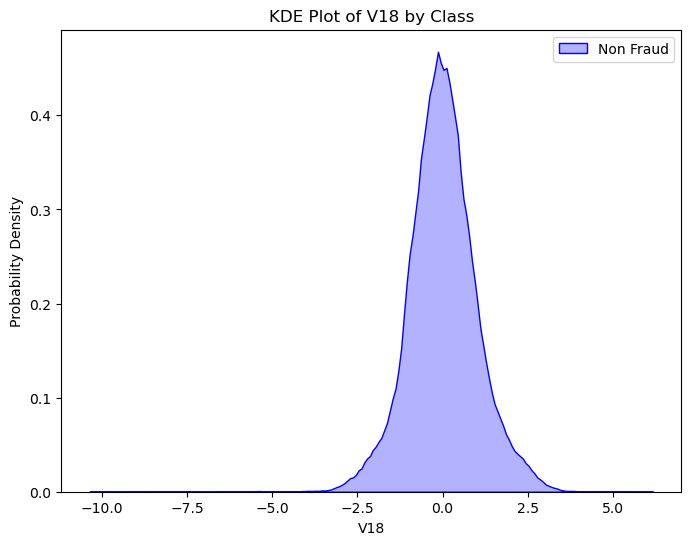

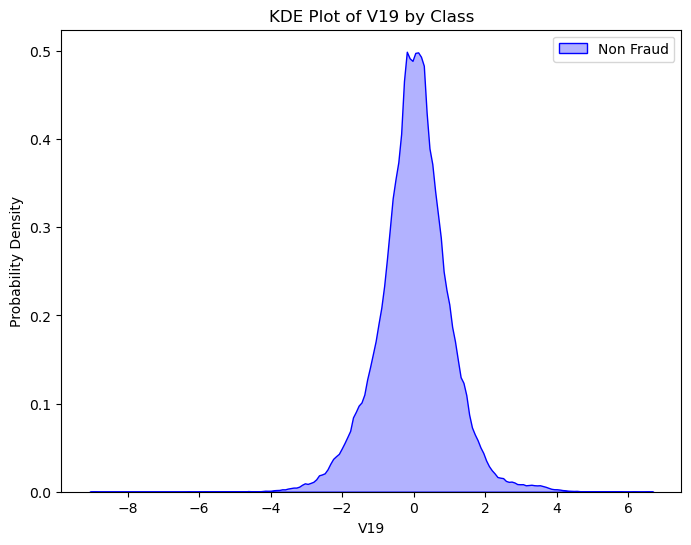

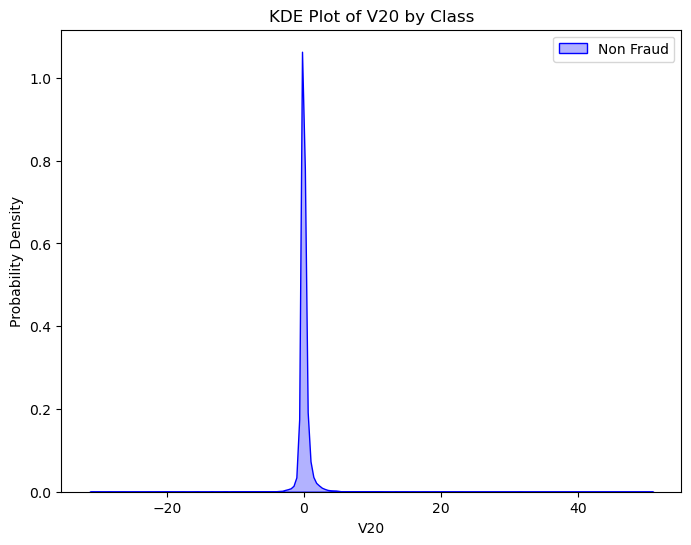

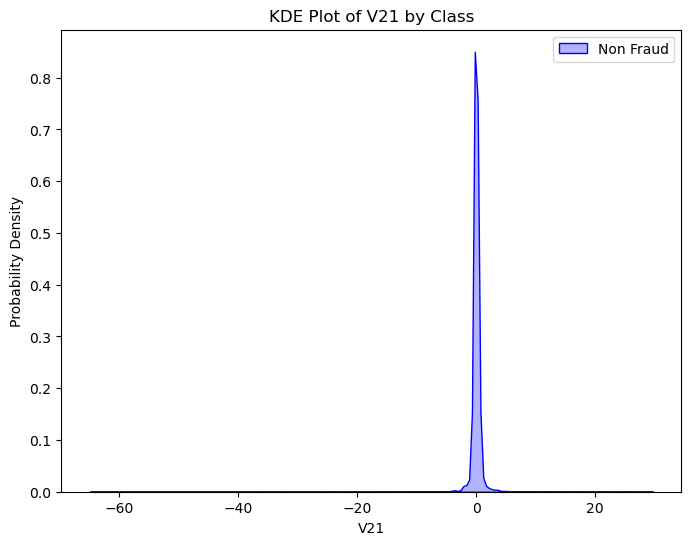

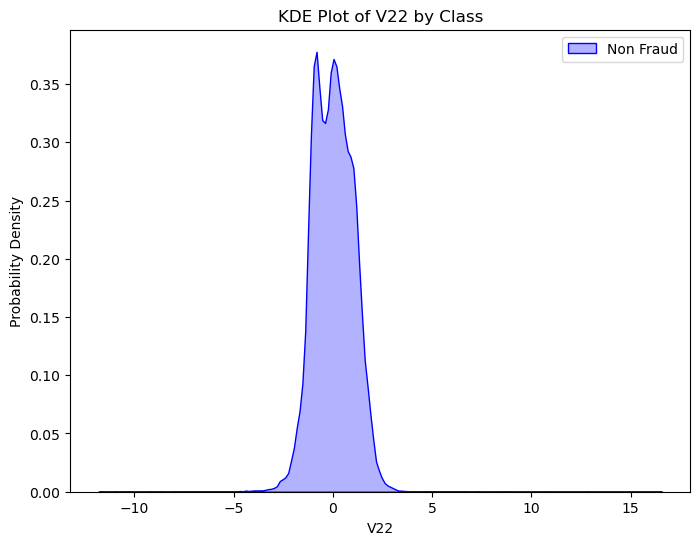

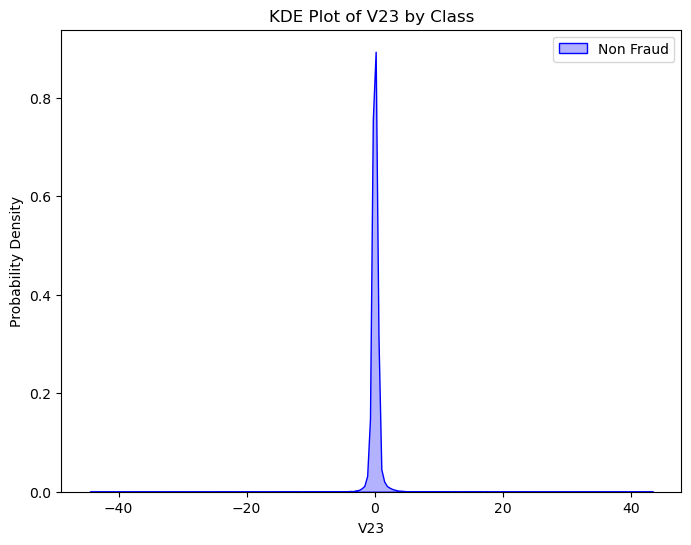

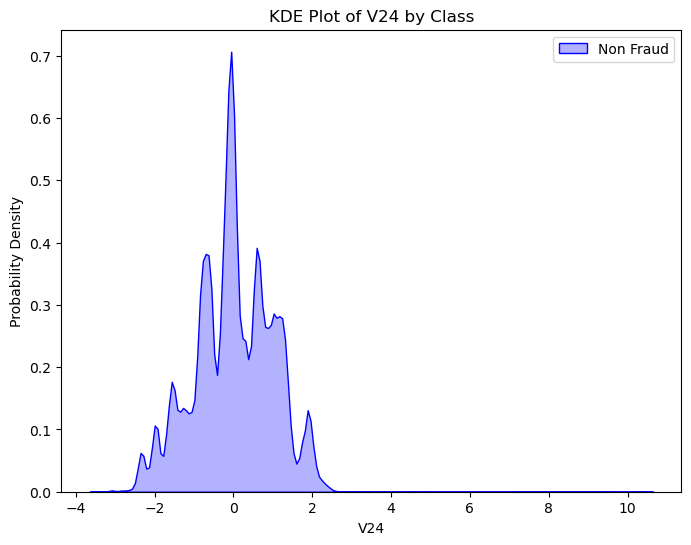

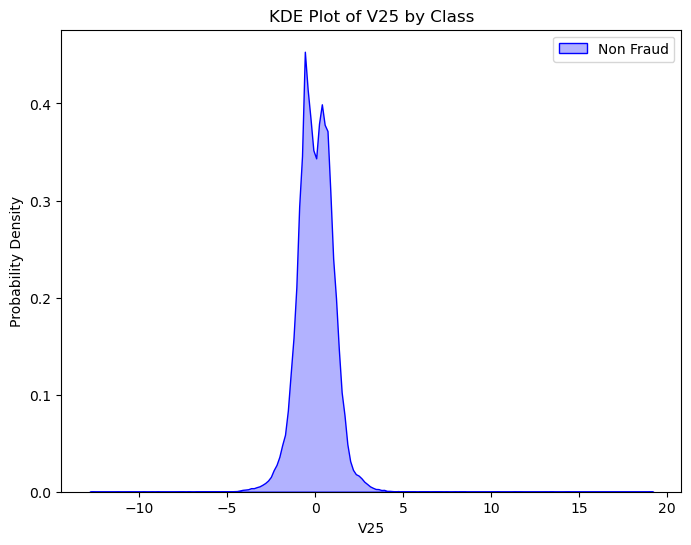

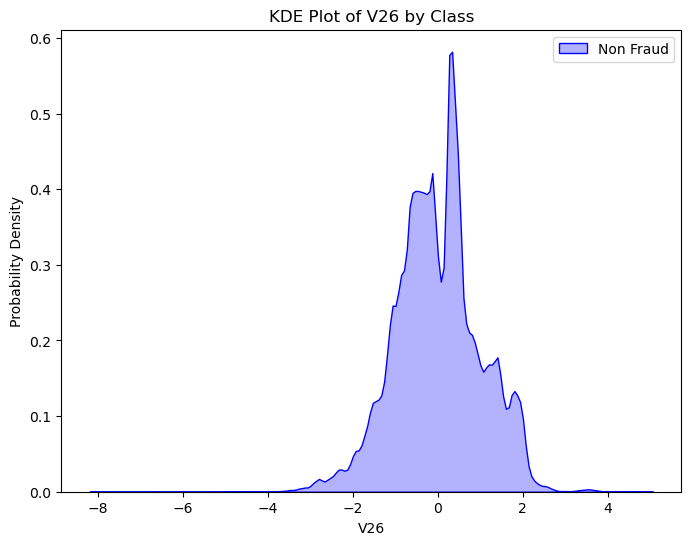

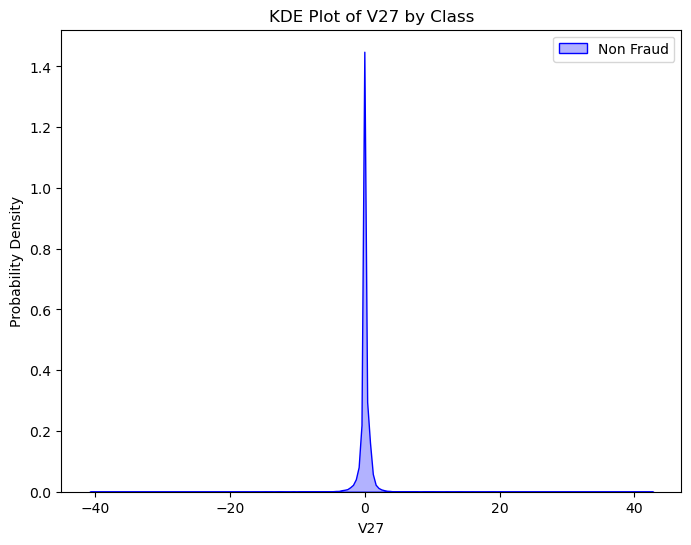

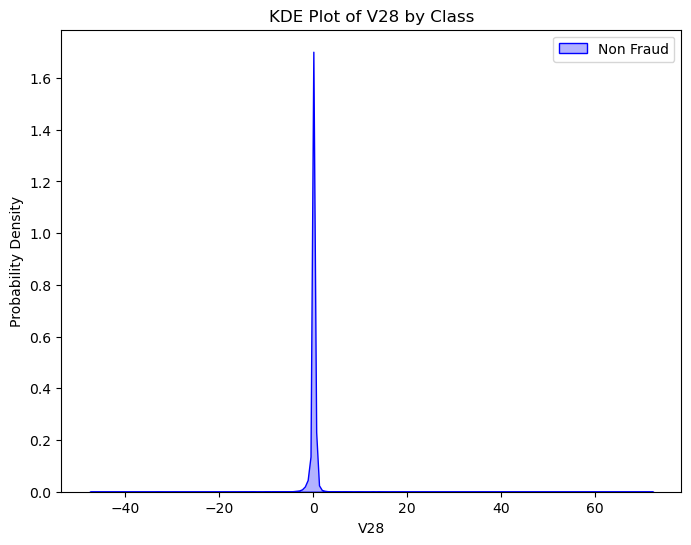

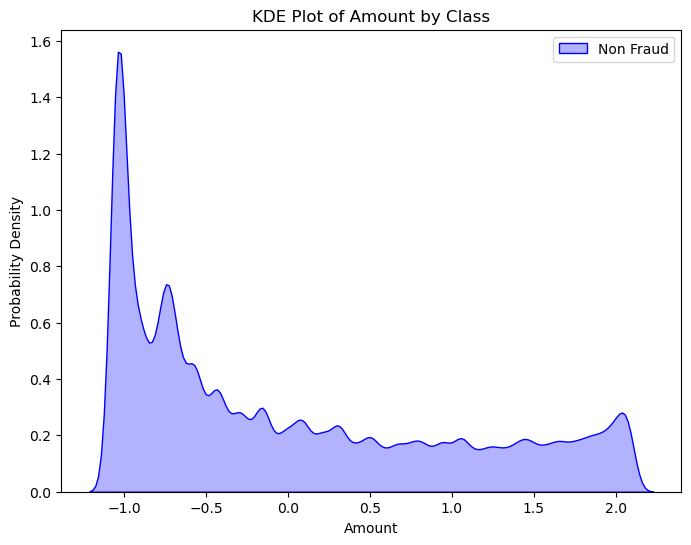

In [779]:
# Plot KDEs for all features
plot_kde_all_features(X_train, X_train.columns)

### Findings: 
Now we can see that all the variables seem to be normallly distributed after transformation

# Modeling on imbalanced data

### Findings:
- As we have seen that the data is heavily imbalanced, where only 0.16% transctions are fraudulent, we should not consider Accuracy as a good measure for evaluating the model.

- Because If the model always predicts the same class (1 or 0) for all the data points, it will result in an accuracy of more than 99%.

- Hence, we have to measure the ROC-AUC score for fair evaluation of the model.

- In other words, accuracy alone may not be a reliable performance metric when dealing with imbalanced datasets. It can be misleading, as it does not capture the model's ability to correctly identify the minority class.

- In such scenarios ROC curve is used to understand the strength of the model by evaluating the performance of the model at all the classification thresholds.

- The default threshold of 0.5 is not always the ideal threshold to find the best classification label of the test point. Because the ROC curve is measured at all thresholds, the best threshold would be one at which the True Positive Rate (TPR) is high and False Positive Rate (FPR) is low, i.e., misclassifications are low.

- After determining the optimal threshold, we can calculate the F1 score of the classifier to measure the precision and recall at the selected threshold.

In [174]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [175]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, random_state=4, shuffle=True)

# specify params
params = {'C': [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(), 
                        param_grid = params, 
                        scoring ='roc_auc', 
                        cv=folds, 
                        verbose=1, 
                        return_train_score=True)

In [176]:
# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [177]:
# results of GridSearchCV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [178]:
cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time', 'mean_train_score']]

,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,mean_train_score
0,{'C': 0.01},0.985980,0.003773,1,0.192952,0.012069,0.987564
1,{'C': 0.1},0.981680,0.005097,2,0.179879,0.010703,0.983890
2,{'C': 1},0.978721,0.005226,3,0.208601,0.017576,0.981762
3,{'C': 10},0.978395,0.005311,4,0.194199,0.013278,0.981514
4,{'C': 100},0.978368,0.005326,5,0.221594,0.014643,0.981491
5,{'C': 1000},0.978365,0.005327,6,0.263622,0.019962,0.981488


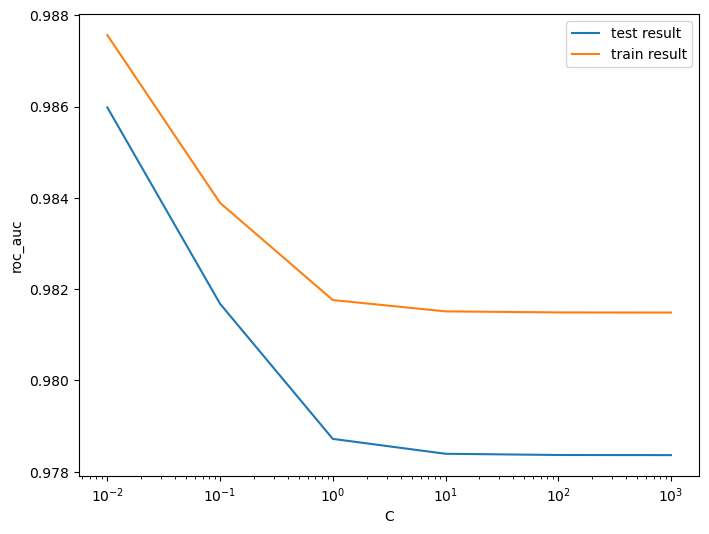

In [179]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper right')
plt.xscale('log')
plt.show()

In [180]:
# best score
best_score = model_cv.best_score_
# best params
best_params = model_cv.best_params_['C']

In [181]:
print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")

Best Score: 0.9859803497225619
Best Params: 0.01


In [183]:
# Create a dataframe to store model performance 
m_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'F1-score', 'ROC-AUC'])

# Function to record the model performance
def show_model_information( df, df_pred, model_name, roc_score, append):
    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(df, df_pred)
    TN = confusion_matrix[0,0] # True negative
    FP = confusion_matrix[0,1] # False positive
    FN = confusion_matrix[1,0] # False negative
    TP = confusion_matrix[1,1] # True positive
    # Accuracy
    print("Accuracy:", metrics.accuracy_score(df, df_pred))

    # Sensitivity
    print("Sensitivity:", TP / float(TP+FN))

    # Specificity
    print("Specificity:", TN / float(TN+FP))

    # F1 score
    print("F1-score:", f1_score(df, df_pred))

    if ( append == True): 
        m_df.loc[len(m_df)] = [model_name, 
        metrics.accuracy_score(df, df_pred) * 100, 
        FP / float(TP+FN), 
        TN / float(TN+FP), 
        f1_score(df, df_pred), 
        roc_score]
    m_df

### Logistic Regression with option parameter based on the above result

In [184]:
# Instantiate the model with best C
logistic_imb = LogisticRegression(C=0.01)

In [185]:
# Fit the model on the train set
logistic_imb_model = logistic_imb.fit(X_train, y_train)

In [186]:
# Predictions on the train set
y_train_pred = logistic_imb_model.predict(X_train)

In [187]:
# classification_report
print(classification_report(y_train, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198277
           1       1.00      1.00      1.00       331

    accuracy                           1.00    198608
   macro avg       1.00      1.00      1.00    198608
weighted avg       1.00      1.00      1.00    198608



### ROC related to Train set

In [188]:
# Predicted probability
y_train_pred_proba = logistic_imb_model.predict_proba(X_train)[:,1]
y_train_pred_proba

array([0.00020455, 0.00023326, 0.00034486, ..., 0.00017653, 0.00028686,
       0.00035537])

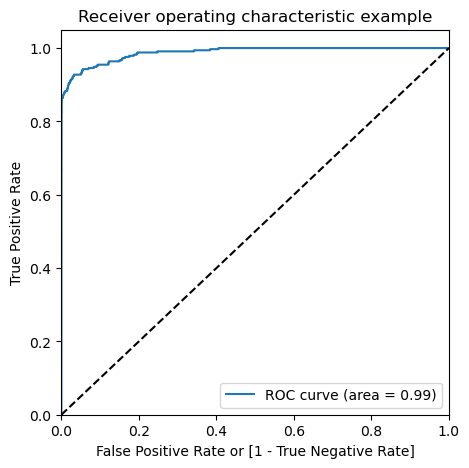

In [189]:
# Plot the ROC curve
roc_score = draw_roc(y_train, y_train_pred_proba)

We acheived very good ROC 0.99 on the train set.

In [190]:
show_model_information(y_train, y_train_pred, 'Logistic Regression - imbalanced', roc_score, False)

Accuracy: 0.9991893579312011
Sensitivity: 0.5891238670694864
Specificity: 0.9998739137671036
F1-score: 0.7078039927404719


### Prediction on Test set

In [191]:
# Prediction on the test set
y_test_pred = logistic_imb_model.predict(X_test)

In [192]:
#show_model_information(y_test, y_test_pred, 'Logistic Regression - Imbalanced', 0, True)

In [193]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.86      0.52      0.65       142

    accuracy                           1.00     85118
   macro avg       0.93      0.76      0.82     85118
weighted avg       1.00      1.00      1.00     85118



### ROC on the Test set

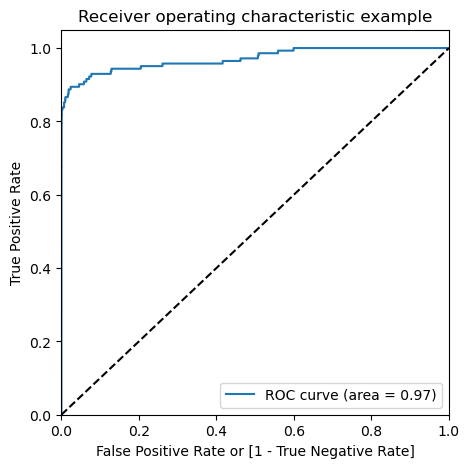

In [194]:
# Predicted probability
y_test_pred_proba = logistic_imb_model.predict_proba(X_test)[:,1]

# Plot the ROC curve
roc_score = draw_roc(y_test, y_test_pred_proba)

We can see that we have very good ROC on the test set i.e. 0.97

Based on the Logistic Regressioin, the Test set performed well.

In [195]:
show_model_information(y_test, y_test_pred, 'Logistic Regression - Imbalanced', roc_score, True)

Accuracy: 0.999060128292488
Sensitivity: 0.5211267605633803
Specificity: 0.9998587836565619
F1-score: 0.6491228070175439


In [196]:
m_df

,Model,Accuracy,Sensitivity,Specificity,F1-score,ROC-AUC
0,Logistic Regression - Imbalanced,99.906013,0.084507,0.999859,0.649123,0.970236


# Decision Tree

In [198]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [199]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.302821,0.075917,0.016045,0.000516,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.927299,0.934993,0.908353,0.923548,0.011194,8
1,3.224506,0.013847,0.015618,0.000402,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.936367,0.934993,0.908353,0.926571,0.012894,5
2,3.171373,0.040877,0.023556,0.006123,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.956387,0.947680,0.903138,0.935735,0.023322,2
3,3.331301,0.060919,0.017513,0.002291,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.956387,0.947623,0.903138,0.935716,0.023312,3
4,6.357093,0.029524,0.017189,0.010456,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.947482,0.949154,0.907377,0.934671,0.019312,4
5,6.167364,0.101352,0.017277,0.001733,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.956380,0.949147,0.907327,0.937618,0.021621,1
6,6.119906,0.356870,0.020143,0.005992,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.924089,0.940094,0.907245,0.923809,0.013412,6
7,4.916882,0.830750,0.012934,0.002568,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.924089,0.940046,0.907245,0.923793,0.013393,7


In [200]:
grid_search.best_score_

0.9376181216478484

In [201]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100)


In [202]:
# Model with optimal hyperparameters
dt_imb_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)

dt_imb_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100,
                       random_state=100)

In [203]:
# Predictions on the train set
y_train_pred = dt_imb_model.predict(X_train)

In [204]:
show_model_information(y_train, y_train_pred, 'Decision Tree - Imbalanced', 0, False)

Accuracy: 0.9991994280190123
Sensitivity: 0.649546827794562
Specificity: 0.9997831316794182
F1-score: 0.7300509337860781


In [205]:
# classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198277
           1       0.83      0.65      0.73       331

    accuracy                           1.00    198608
   macro avg       0.92      0.82      0.86    198608
weighted avg       1.00      1.00      1.00    198608



In [206]:
# Predicted probability
y_train_pred_proba = dt_imb_model.predict_proba(X_train)[:,1]

In [207]:
# roc_auc
auc = metrics.roc_auc_score(y_train, y_train_pred_proba)
auc

0.9832263027553371

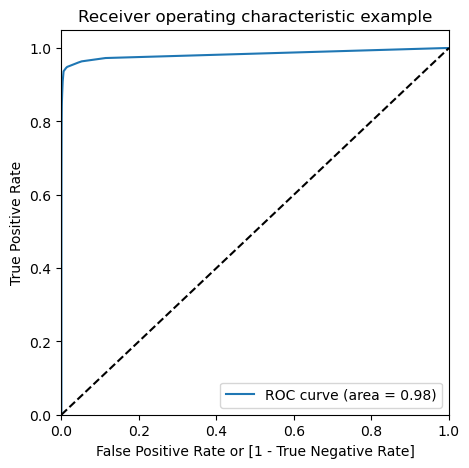

In [208]:
# Plot the ROC curve
roc_score = draw_roc(y_train, y_train_pred_proba)

In [209]:
# Predictions on the test set
y_test_pred = dt_imb_model.predict(X_test)

In [210]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.84      0.61      0.71       142

    accuracy                           1.00     85118
   macro avg       0.92      0.81      0.85     85118
weighted avg       1.00      1.00      1.00     85118



In [211]:
# Predicted probability
y_test_pred_proba = dt_imb_model.predict_proba(X_test)[:,1]

In [212]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9239484934934403

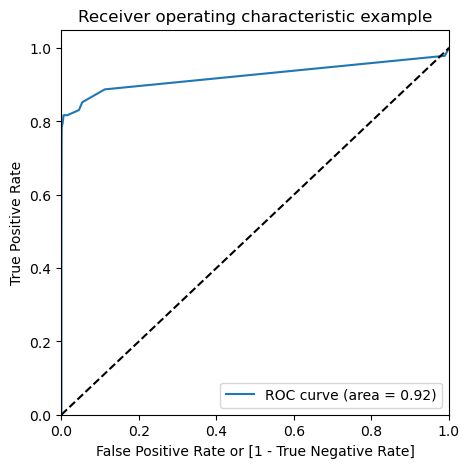

In [213]:
# Plot the ROC curve
roc_score = draw_roc(y_test, y_test_pred_proba)

In [214]:
show_model_information(y_test, y_test_pred, 'Decision Tree - Imbalanced', roc_score, True)

Accuracy: 0.9991541154632393
Sensitivity: 0.6126760563380281
Specificity: 0.9997999435134626
F1-score: 0.7073170731707317


In [215]:
m_df

,Model,Accuracy,Sensitivity,Specificity,F1-score,ROC-AUC
0,Logistic Regression - Imbalanced,99.906013,0.084507,0.999859,0.649123,0.970236
1,Decision Tree - Imbalanced,99.915412,0.119718,0.999800,0.707317,0.923948


## Random forest

In [216]:
param_grid = {
    'max_depth': range(5,10,5) ,
    'min_samples_leaf': [50, 100],
    'min_samples_split': [50, 100],
    'n_estimators': [100,200], 
    'max_features': [10, 20]
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 2,
                           n_jobs = -1,
                           verbose = 1, 
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10, 5), 'max_features': [10, 20],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [50, 100],
                         'n_estimators': [100, 200]},
             return_train_score=True, verbose=1)

In [217]:
grid_search.best_score_

0.99917928784339

In [218]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 10,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'n_estimators': 200}

In [219]:
# model with the best hyperparameters

rfc_imb_model = RandomForestClassifier(bootstrap=True,
                                        max_depth = 5,
                                        max_features = 10,
                                        min_samples_leaf = 50,
                                        min_samples_split = 100,
                                        n_estimators = 200)

In [220]:
# Fit the model
rfc_imb_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=100, n_estimators=200)

In [221]:
# predictions on train test
y_train_pred = rfc_imb_model.predict(X_train)

In [222]:
show_model_information(y_train, y_train_pred, 'Random Forest - Imbalanced', 0, False)

Accuracy: 0.9993001288971239
Sensitivity: 0.6978851963746223
Specificity: 0.9998033054766816
F1-score: 0.7687188019966722


In [223]:
# classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198277
           1       0.86      0.70      0.77       331

    accuracy                           1.00    198608
   macro avg       0.93      0.85      0.88    198608
weighted avg       1.00      1.00      1.00    198608



In [224]:
# Predicted probability
y_train_pred_proba = rfc_imb_model.predict_proba(X_train)[:,1]

In [225]:
# roc_auc
auc = metrics.roc_auc_score(y_train, y_train_pred_proba)
auc

0.9864602051202835

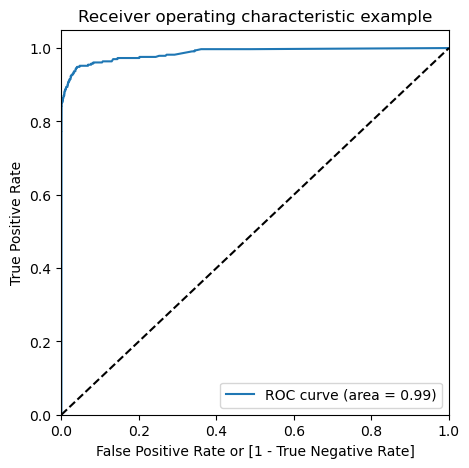

0.9864602051202835

In [226]:
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [227]:
# Predicted probability
y_test_pred_proba = rfc_imb_model.predict_proba(X_test)[:,1]

In [228]:
# Predictions on the test set
y_test_pred = rfc_imb_model.predict(X_test)

In [229]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.86      0.68      0.76       142

    accuracy                           1.00     85118
   macro avg       0.93      0.84      0.88     85118
weighted avg       1.00      1.00      1.00     85118



In [230]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9731915606328615

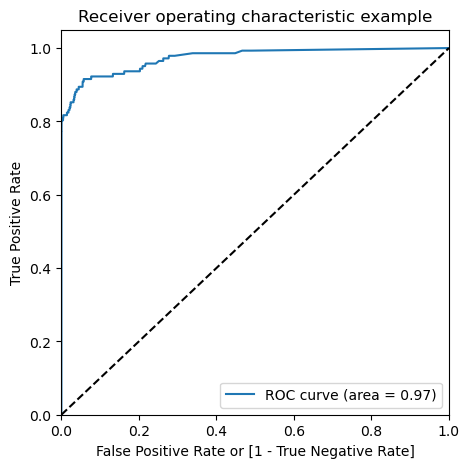

In [231]:
# Plot the ROC curve
roc_score = draw_roc(y_test, y_test_pred_proba)


In [232]:
show_model_information(y_test, y_test_pred, 'Random Forest - Imbalanced', roc_score, True)

Accuracy: 0.9992833478230222
Sensitivity: 0.676056338028169
Specificity: 0.9998234795707023
F1-score: 0.758893280632411


## Overall Summary of the model related to imbalanced data

In [234]:
m_df

,Model,Accuracy,Sensitivity,Specificity,F1-score,ROC-AUC
0,Logistic Regression - Imbalanced,99.906013,0.084507,0.999859,0.649123,0.970236
1,Decision Tree - Imbalanced,99.915412,0.119718,0.999800,0.707317,0.923948
2,Random Forest - Imbalanced,99.928335,0.105634,0.999823,0.758893,0.973192


We can see that among all the models we tried (Logistic, Decision Tree, and Random Forest), almost all of them have performed well.
But if we were to choose one of them , we can go for the best as Random Forest with better accuracy and F1-score.

In [235]:
# Address imbalanced data before running the final model.

In [236]:
# Importing SMOTE
from imblearn.over_sampling import SMOTE

In [237]:
# instantiate SMOTE
sm = SMOTE(random_state=27)

# fitting the SMOTE to the train set
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [238]:
print('Before oversampling X_train shape=',X_train.shape)
print('After oversampling X_train shape=',X_train_smote.shape)

Before oversampling X_train shape= (198608, 29)
After oversampling X_train shape= (396554, 29)


### Logistic Regression (by SMOTE)

In [239]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as roc-auc
model_cv = GridSearchCV(estimator = LogisticRegression(), param_grid = params, scoring= 'roc_auc', cv = folds, verbose = 1, return_train_score=True) 

# Fit the model
model_cv.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [240]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.737353,0.032818,0.031170,0.000242,0.01,{'C': 0.01},0.990734,0.990982,0.991127,0.990261,...,0.990714,0.000319,6,0.990813,0.990570,0.990619,0.990797,0.990819,0.990723,0.000107
1,0.978925,0.057637,0.046723,0.010621,0.10,{'C': 0.1},0.990983,0.991183,0.991349,0.990502,...,0.990944,0.000309,5,0.991059,0.990786,0.990842,0.991043,0.991033,0.990953,0.000115
2,1.024307,0.054640,0.034690,0.006632,1.00,{'C': 1},0.991055,0.991241,0.991409,0.990547,...,0.991006,0.000311,4,0.991130,0.990847,0.990908,0.991091,0.991101,0.991015,0.000115
3,0.953130,0.067156,0.025468,0.010812,10.00,{'C': 10},0.991067,0.991258,0.991420,0.990586,...,0.991023,0.000305,1,0.991142,0.990865,0.990919,0.991128,0.991104,0.991032,0.000116
4,1.074093,0.107836,0.028233,0.004229,100.00,{'C': 100},0.991065,0.991252,0.991421,0.990585,...,0.991021,0.000304,3,0.991140,0.990859,0.990920,0.991127,0.991103,0.991030,0.000117
5,1.025353,0.090879,0.031788,0.006485,1000.00,{'C': 1000},0.991065,0.991257,0.991421,0.990584,...,0.991022,0.000305,2,0.991140,0.990864,0.990920,0.991126,0.991103,0.991031,0.000115


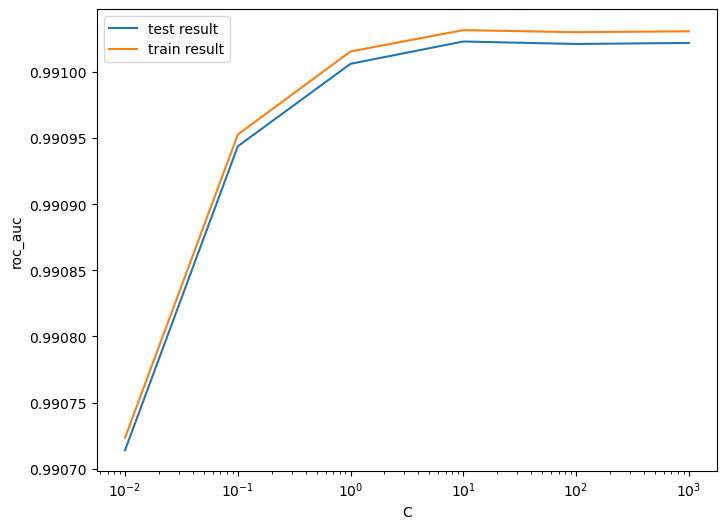

In [241]:
# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='best')
plt.xscale('log')
plt.show()

In [242]:
print(model_cv.best_score_)
print(model_cv.best_params_['C'])

0.9910229187837947
10


In [243]:
# Instantiate the model with best C
logistic_bal_smote = LogisticRegression(C=100)

In [244]:
# Fit the model on the train set
logistic_bal_smote_model = logistic_bal_smote.fit(X_train_smote, y_train_smote)

In [245]:
# Prediction on the train set
y_train_pred = logistic_bal_smote_model.predict(X_train_smote)

In [246]:
show_model_information(y_train_smote, y_train_pred, 'Logistic Regression - SMOTE', 0, False)

Accuracy: 0.9494116816373054
Sensitivity: 0.9258865123034946
Specificity: 0.9729368509711162
F1-score: 0.9481929110981987


In [247]:
# classification_report
print(classification_report(y_train_smote, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95    198277
           1       0.97      0.93      0.95    198277

    accuracy                           0.95    396554
   macro avg       0.95      0.95      0.95    396554
weighted avg       0.95      0.95      0.95    396554



In [248]:
# Predicted probability
y_train_pred_proba_log_bal_smote = logistic_bal_smote_model.predict_proba(X_train_smote)[:,1]

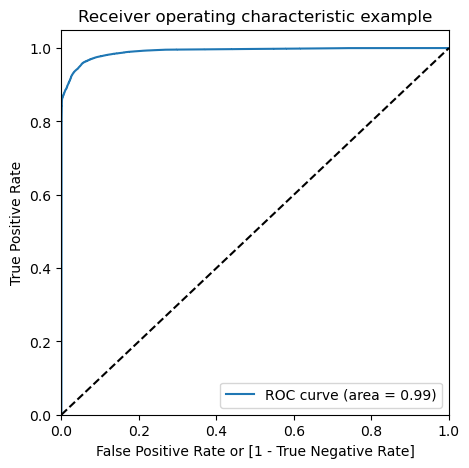

In [249]:
# Plot the ROC curve
roc_score = draw_roc(y_train_smote, y_train_pred_proba_log_bal_smote)

In [250]:
# Prediction on the test set
y_test_pred = logistic_bal_smote_model.predict(X_test)

In [251]:
#show_model_information(y_test, y_test_pred, 'Logistic Regression - SMOTE', True)

In [252]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.88      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



In [253]:
# Predicted probability
y_test_pred_proba = logistic_bal_smote_model.predict_proba(X_test)[:,1]

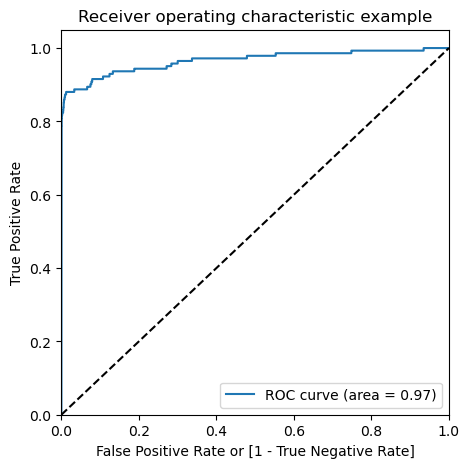

In [254]:
# Plot the ROC curve
roc_score = draw_roc(y_test, y_test_pred_proba)

In [255]:
show_model_information(y_test, y_test_pred, 'Logistic Regression - SMOTE', roc_score, True)

Accuracy: 0.9721210554759275
Sensitivity: 0.8802816901408451
Specificity: 0.9722745245716438
F1-score: 0.09531071292413268


In [256]:
m_df

,Model,Accuracy,Sensitivity,Specificity,F1-score,ROC-AUC
0,Logistic Regression - Imbalanced,99.906013,0.084507,0.999859,0.649123,0.970236
1,Decision Tree - Imbalanced,99.915412,0.119718,0.999800,0.707317,0.923948
2,Random Forest - Imbalanced,99.928335,0.105634,0.999823,0.758893,0.973192
3,Logistic Regression - SMOTE,97.212106,16.591549,0.972275,0.095311,0.965722


### Decision Tree with SMOTE

In [257]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [258]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.358000,0.026091,0.045398,0.008521,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.987706,0.987610,0.988171,0.987829,0.000245,8
1,6.854215,0.450617,0.031905,0.003410,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.987708,0.987610,0.988176,0.987831,0.000247,7
2,6.532213,0.093875,0.044144,0.003876,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.987825,0.987578,0.988157,0.987853,0.000237,5
3,6.598953,0.224723,0.043770,0.008764,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.987825,0.987578,0.988157,0.987853,0.000237,5
4,13.156932,0.389209,0.057881,0.005061,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.997947,0.998358,0.998233,0.998179,0.000172,1
5,11.585454,0.176654,0.046373,0.001348,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.997937,0.998299,0.998262,0.998166,0.000163,2
6,11.685648,0.077194,0.050619,0.009396,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.998027,0.998085,0.998291,0.998134,0.000114,3
7,11.867626,0.264642,0.058802,0.006240,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.998055,0.998117,0.998212,0.998128,0.000065,4


In [259]:
grid_search.best_score_

0.9981794436738317

In [260]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)

In [261]:
# Model with optimal hyperparameters
dt_bal_smote_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_bal_smote_model.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

In [262]:
# Predictions on the train set
y_train_pred = dt_bal_smote_model.predict(X_train_smote)

In [263]:
show_model_information(y_train_smote, y_train_pred, 'DecisionTree - SMOTE', 0, False)

Accuracy: 0.9907276184327986
Sensitivity: 0.9925709991577439
Specificity: 0.9888842377078532
F1-score: 0.990744679512189


In [264]:
# classification_report
print(classification_report(y_train_smote, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    198277
           1       0.99      0.99      0.99    198277

    accuracy                           0.99    396554
   macro avg       0.99      0.99      0.99    396554
weighted avg       0.99      0.99      0.99    396554



In [265]:
# Predicted probability
y_train_pred_proba = dt_bal_smote_model.predict_proba(X_train_smote)[:,1]

In [266]:
# roc_auc
auc = metrics.roc_auc_score(y_train_smote, y_train_pred_proba)
auc

0.9989125661344072

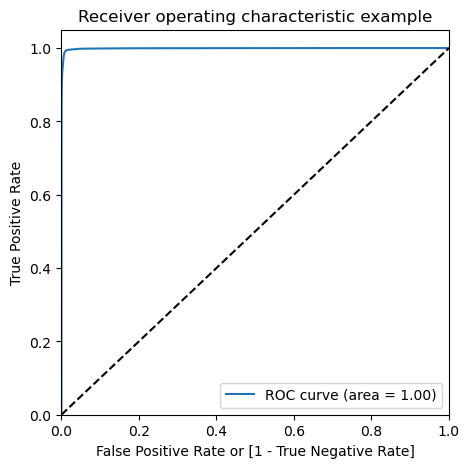

0.9989125661344072

In [267]:
# Plot the ROC curve
draw_roc(y_train_smote, y_train_pred_proba)

In [268]:
# Predictions on the test set
y_test_pred = dt_bal_smote_model.predict(X_test)

In [269]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     84976
           1       0.10      0.82      0.18       142

    accuracy                           0.99     85118
   macro avg       0.55      0.90      0.59     85118
weighted avg       1.00      0.99      0.99     85118



In [270]:
# Predicted probability
y_test_pred_proba = dt_bal_smote_model.predict_proba(X_test)[:,1]

In [271]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.922377295925809

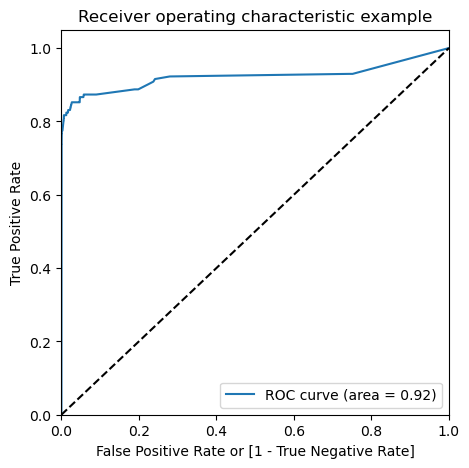

In [272]:
# Plot the ROC curve
roc_score = draw_roc(y_test, y_test_pred_proba)

In [273]:
show_model_information(y_test, y_test_pred, 'DecisionTree - SMOTE', roc_score, True)

Accuracy: 0.9879461453511595
Sensitivity: 0.8169014084507042
Specificity: 0.9882319713801544
F1-score: 0.18441971383147854


In [274]:
m_df

,Model,Accuracy,Sensitivity,Specificity,F1-score,ROC-AUC
0,Logistic Regression - Imbalanced,99.906013,0.084507,0.999859,0.649123,0.970236
1,Decision Tree - Imbalanced,99.915412,0.119718,0.999800,0.707317,0.923948
2,Random Forest - Imbalanced,99.928335,0.105634,0.999823,0.758893,0.973192
3,Logistic Regression - SMOTE,97.212106,16.591549,0.972275,0.095311,0.965722
4,DecisionTree - SMOTE,98.794615,7.042254,0.988232,0.184420,0.922377


#### After addressing the imbalanced data issue, looks like the Decision Tree has performed well. But will add the Random Forest and evaluate the model as part of the final project.

### Print the FPR,TPR & select the best threshold from the roc curve for the best model

In [ ]:
# Work needs to be done here
# Will add the m_df dataframe both FPR and TPR values for all the models if time allows.

## Plan is to additional models

In [389]:
# Will try to add additional models if required

## Additional information will be delivered as part of the final deliverable.